# Dependencies

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import os, time, re
from tqdm import tqdm
from typing import List, Dict, Callable
from collections import Counter

import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import FastText
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import save_npz, load_npz

pd.set_option('display.max_colwidth', None)

In [2]:
FOLDER_CSV_PATH = 'Dataset'
FILES = [file for file in os.listdir(FOLDER_CSV_PATH) if file.endswith('.csv')]
GROUND_TRUTH = [9534, 9431, 8826, 120, 1190]

# Get Dataframe

In [3]:
dataframes = []

for file in FILES:
    file_path = os.path.join(FOLDER_CSV_PATH, file)
    try:
        df = pd.read_csv(file_path)
        if 'Unnamed: 0' in df.columns:
            print(f"Kolom 'Unnamed: 0' ditemukan di file: {file}")
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading file {file}: {e}")

Kolom 'Unnamed: 0' ditemukan di file: Amazon-Products.csv


There is an error in file `Amazon-Products.csv`, we need to fix it first

In [4]:
df_amazonproducts = pd.read_csv('Dataset\Amazon-Products.csv')
df_amazonproducts.head()

,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,0,"Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1 Convertible, Copper, Anti-Viral + Pm 2.5 Filter, 2023 Model, White, Gls18I3...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sYL._AC_UL320_.jpg,https://www.amazon.in/Lloyd-Inverter-Convertible-Anti-Viral-GLS18I3FWAMC/dp/B0BRKXTSBT/ref=sr_1_4?qid=1679134237&s=kitchen&sr=1-4,4.2,"2,255","₹32,999","₹58,990"
1,1,"LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (Copper, Super Convertible 6-in-1 Cooling, HD Filter with Anti-Virus Protectio...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctDL._AC_UL320_.jpg,https://www.amazon.in/LG-Convertible-Anti-Virus-Protection-RS-Q19YNZE/dp/B0BQ3MXML8/ref=sr_1_5?qid=1679134237&s=kitchen&sr=1-5,4.2,"2,948","₹46,490","₹75,990"
2,2,"LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Copper, Super Convertible 6-In-1 Cooling, Hd Filter With Anti Virus Protection,...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctDL._AC_UL320_.jpg,https://www.amazon.in/LG-Inverter-Convertible-protection-RS-Q13JNYE/dp/B0BPYN9JGF/ref=sr_1_6?qid=1679134237&s=kitchen&sr=1-6,4.2,"1,206","₹34,490","₹61,990"
3,3,"LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (Copper, Super Convertible 6-in-1 Cooling, HD Filter with Anti-Virus Protectio...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctDL._AC_UL320_.jpg,https://www.amazon.in/LG-Convertible-Anti-Virus-Protection-RS-Q19JNXE/dp/B0BQ3MJ1TG/ref=sr_1_7?qid=1679134237&s=kitchen&sr=1-7,4.0,69,"₹37,990","₹68,990"
4,4,"Carrier 1.5 Ton 3 Star Inverter Split AC (Copper,ESTER Dxi, 4-in-1 Flexicool Inverter, 2022 Model,R32,White)",appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiWL._AC_UL320_.jpg,https://www.amazon.in/Carrier-Inverter-Split-Copper-Flexicool/dp/B0B67RLLJC/ref=sr_1_8?qid=1679134237&s=kitchen&sr=1-8,4.1,630,"₹34,490","₹67,790"


The issue was in the index, we can drop it after combined it

In [5]:
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,Unnamed: 0
0,"Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1 Convertible, Copper, Anti-Viral + Pm 2.5 Filter, 2023 Model, White, Gls18I3...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sYL._AC_UL320_.jpg,https://www.amazon.in/Lloyd-Inverter-Convertible-Anti-Viral-GLS18I3FWAMC/dp/B0BRKXTSBT/ref=sr_1_4?qid=1679134237&s=kitchen&sr=1-4,4.2,"2,255","₹32,999","₹58,990",NaN
1,"LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (Copper, Super Convertible 6-in-1 Cooling, HD Filter with Anti-Virus Protectio...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctDL._AC_UL320_.jpg,https://www.amazon.in/LG-Convertible-Anti-Virus-Protection-RS-Q19YNZE/dp/B0BQ3MXML8/ref=sr_1_5?qid=1679134237&s=kitchen&sr=1-5,4.2,"2,948","₹46,490","₹75,990",NaN
2,"LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Copper, Super Convertible 6-In-1 Cooling, Hd Filter With Anti Virus Protection,...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctDL._AC_UL320_.jpg,https://www.amazon.in/LG-Inverter-Convertible-protection-RS-Q13JNYE/dp/B0BPYN9JGF/ref=sr_1_6?qid=1679134237&s=kitchen&sr=1-6,4.2,"1,206","₹34,490","₹61,990",NaN
3,"LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (Copper, Super Convertible 6-in-1 Cooling, HD Filter with Anti-Virus Protectio...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctDL._AC_UL320_.jpg,https://www.amazon.in/LG-Convertible-Anti-Virus-Protection-RS-Q19JNXE/dp/B0BQ3MJ1TG/ref=sr_1_7?qid=1679134237&s=kitchen&sr=1-7,4.0,69,"₹37,990","₹68,990",NaN
4,"Carrier 1.5 Ton 3 Star Inverter Split AC (Copper,ESTER Dxi, 4-in-1 Flexicool Inverter, 2022 Model,R32,White)",appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiWL._AC_UL320_.jpg,https://www.amazon.in/Carrier-Inverter-Split-Copper-Flexicool/dp/B0B67RLLJC/ref=sr_1_8?qid=1679134237&s=kitchen&sr=1-8,4.1,630,"₹34,490","₹67,790",NaN


In [6]:
combined_df.drop(columns='Unnamed: 0', inplace=True)
combined_df.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,"Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1 Convertible, Copper, Anti-Viral + Pm 2.5 Filter, 2023 Model, White, Gls18I3...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sYL._AC_UL320_.jpg,https://www.amazon.in/Lloyd-Inverter-Convertible-Anti-Viral-GLS18I3FWAMC/dp/B0BRKXTSBT/ref=sr_1_4?qid=1679134237&s=kitchen&sr=1-4,4.2,"2,255","₹32,999","₹58,990"
1,"LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (Copper, Super Convertible 6-in-1 Cooling, HD Filter with Anti-Virus Protectio...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctDL._AC_UL320_.jpg,https://www.amazon.in/LG-Convertible-Anti-Virus-Protection-RS-Q19YNZE/dp/B0BQ3MXML8/ref=sr_1_5?qid=1679134237&s=kitchen&sr=1-5,4.2,"2,948","₹46,490","₹75,990"
2,"LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Copper, Super Convertible 6-In-1 Cooling, Hd Filter With Anti Virus Protection,...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctDL._AC_UL320_.jpg,https://www.amazon.in/LG-Inverter-Convertible-protection-RS-Q13JNYE/dp/B0BPYN9JGF/ref=sr_1_6?qid=1679134237&s=kitchen&sr=1-6,4.2,"1,206","₹34,490","₹61,990"
3,"LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (Copper, Super Convertible 6-in-1 Cooling, HD Filter with Anti-Virus Protectio...",appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctDL._AC_UL320_.jpg,https://www.amazon.in/LG-Convertible-Anti-Virus-Protection-RS-Q19JNXE/dp/B0BQ3MJ1TG/ref=sr_1_7?qid=1679134237&s=kitchen&sr=1-7,4.0,69,"₹37,990","₹68,990"
4,"Carrier 1.5 Ton 3 Star Inverter Split AC (Copper,ESTER Dxi, 4-in-1 Flexicool Inverter, 2022 Model,R32,White)",appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiWL._AC_UL320_.jpg,https://www.amazon.in/Carrier-Inverter-Split-Copper-Flexicool/dp/B0B67RLLJC/ref=sr_1_8?qid=1679134237&s=kitchen&sr=1-8,4.1,630,"₹34,490","₹67,790"


We also need to drop unused columns like image and link

In [7]:
combined_df.drop(columns=['image', 'link'], inplace=True)
combined_df.head()

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
0,"Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1 Convertible, Copper, Anti-Viral + Pm 2.5 Filter, 2023 Model, White, Gls18I3...",appliances,Air Conditioners,4.2,"2,255","₹32,999","₹58,990"
1,"LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (Copper, Super Convertible 6-in-1 Cooling, HD Filter with Anti-Virus Protectio...",appliances,Air Conditioners,4.2,"2,948","₹46,490","₹75,990"
2,"LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Copper, Super Convertible 6-In-1 Cooling, Hd Filter With Anti Virus Protection,...",appliances,Air Conditioners,4.2,"1,206","₹34,490","₹61,990"
3,"LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (Copper, Super Convertible 6-in-1 Cooling, HD Filter with Anti-Virus Protectio...",appliances,Air Conditioners,4.0,69,"₹37,990","₹68,990"
4,"Carrier 1.5 Ton 3 Star Inverter Split AC (Copper,ESTER Dxi, 4-in-1 Flexicool Inverter, 2022 Model,R32,White)",appliances,Air Conditioners,4.1,630,"₹34,490","₹67,790"


In [8]:
combined_df.dtypes

name              object
main_category     object
sub_category      object
ratings           object
no_of_ratings     object
discount_price    object
actual_price      object
dtype: object

In [9]:
combined_df.shape

(1103170, 7)

# Cleaning

## Clean currency

In [10]:
def clean_currency(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame: 
    """
    Removes currency symbols and commas from specified columns and converts them to float type.
    Args:
        df (pd.DataFrame): The DataFrame to process.
        columns (List[str]): A list of column names to clean.
        
    Returns:
        pd.DataFrame: The DataFrame with cleaned and converted columns.
    
    Raises:
        ValueError: If any specified column is not found in the DataFrame.
    """

    for col in columns:
        if col in df.columns:
            # Remove currency symbol (₹) and commas
            df[col] = df[col].astype(str).str.replace('₹', '', regex=False)
            df[col] = df[col].str.replace(',', '', regex=False)
            
            # Convert column values to float
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            # Raise an error if the column is not found
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    return df

In [11]:
clean_currency(combined_df, ['discount_price', 'actual_price'])
combined_df.head()

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
0,"Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1 Convertible, Copper, Anti-Viral + Pm 2.5 Filter, 2023 Model, White, Gls18I3...",appliances,Air Conditioners,4.2,"2,255",32999.0,58990.0
1,"LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (Copper, Super Convertible 6-in-1 Cooling, HD Filter with Anti-Virus Protectio...",appliances,Air Conditioners,4.2,"2,948",46490.0,75990.0
2,"LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Copper, Super Convertible 6-In-1 Cooling, Hd Filter With Anti Virus Protection,...",appliances,Air Conditioners,4.2,"1,206",34490.0,61990.0
3,"LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (Copper, Super Convertible 6-in-1 Cooling, HD Filter with Anti-Virus Protectio...",appliances,Air Conditioners,4.0,69,37990.0,68990.0
4,"Carrier 1.5 Ton 3 Star Inverter Split AC (Copper,ESTER Dxi, 4-in-1 Flexicool Inverter, 2022 Model,R32,White)",appliances,Air Conditioners,4.1,630,34490.0,67790.0


## Clean point and commas in ratings and no_of_ratings

In [12]:
def clean_columns(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Cleans the 'ratings' and 'no_of_ratings' columns in the DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to process.
        
    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """

    for col in columns:
        if col in df.columns:
            # Remove commas
            df[col] = df[col].astype(str).str.replace(",", "", regex=False)
            # Convert to float
            df[col] = pd.to_numeric(df[col], errors="coerce")
        else:
            # Raise an error if the column is not found
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    return df
    

In [13]:
clean_columns(combined_df, ['ratings', 'no_of_ratings'])
combined_df.head()

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
0,"Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1 Convertible, Copper, Anti-Viral + Pm 2.5 Filter, 2023 Model, White, Gls18I3...",appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0
1,"LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (Copper, Super Convertible 6-in-1 Cooling, HD Filter with Anti-Virus Protectio...",appliances,Air Conditioners,4.2,2948.0,46490.0,75990.0
2,"LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Copper, Super Convertible 6-In-1 Cooling, Hd Filter With Anti Virus Protection,...",appliances,Air Conditioners,4.2,1206.0,34490.0,61990.0
3,"LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (Copper, Super Convertible 6-in-1 Cooling, HD Filter with Anti-Virus Protectio...",appliances,Air Conditioners,4.0,69.0,37990.0,68990.0
4,"Carrier 1.5 Ton 3 Star Inverter Split AC (Copper,ESTER Dxi, 4-in-1 Flexicool Inverter, 2022 Model,R32,White)",appliances,Air Conditioners,4.1,630.0,34490.0,67790.0


In [14]:
combined_df.dtypes

name               object
main_category      object
sub_category       object
ratings           float64
no_of_ratings     float64
discount_price    float64
actual_price      float64
dtype: object

## Check duplicate

Check for duplicates in the 'name', 'main_category', and 'actual_price' columns. Based on my analysis, these three columns are sufficient to serve as uniqueness markers for the items.

In [15]:
combined_df.duplicated(subset=['name', 'main_category', 'actual_price']).sum()

660249

In [16]:
duplicated_rows = combined_df[combined_df.duplicated(subset=['name', 'main_category', 'actual_price'], keep=False)]
duplicated_rows.sort_values(by='name')

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
375900,""" SF-400A"" ,10kg x 1gm kitchen weighing scale | food scale | Electronic weight machine for health and fitness | Digital mu...",appliances,Kitchen & Home Appliances,NaN,NaN,415.0,899.0
10092,""" SF-400A"" ,10kg x 1gm kitchen weighing scale | food scale | Electronic weight machine for health and fitness | Digital mu...",appliances,All Appliances,NaN,NaN,415.0,899.0
898733,""" SF-400A"" ,10kg x 1gm kitchen weighing scale | food scale | Electronic weight machine for health and fitness | Digital mu...",appliances,Kitchen & Home Appliances,NaN,NaN,415.0,899.0
38844,""" SF-400A"" ,10kg x 1gm kitchen weighing scale | food scale | Electronic weight machine for health and fitness | Digital mu...",appliances,All Appliances,NaN,NaN,415.0,899.0
583361,"""7"" Embroidery Sleeveless T Shirt with Shorts",kids' fashion,Baby Fashion,NaN,NaN,379.0,599.0
...,...,...,...,...,...,...,...
899535,"﻿﻿Lifelong Digital Air Fryer LLHFD722 , 7.5 Litre XL LED Touch Screen, 12 Preset Cooking Modes, 1400 W , 85% Fat Reduced, ...",appliances,Kitchen & Home Appliances,4.6,6.0,7026.0,12000.0
14615,𝟐𝟎𝟐𝟐 𝐔𝐩𝐠𝐫𝐚𝐝𝐞𝐝 for Apple Watch Charger Magnetic Fast Charging Cable [Portable] Magnetic Wireless Charging Compa...,"tv, audio & cameras",All Electronics,3.2,5.0,299.0,999.0
43367,𝟐𝟎𝟐𝟐 𝐔𝐩𝐠𝐫𝐚𝐝𝐞𝐝 for Apple Watch Charger Magnetic Fast Charging Cable [Portable] Magnetic Wireless Charging Compa...,"tv, audio & cameras",All Electronics,3.2,5.0,299.0,999.0
781220,🌿Ecofrolic Square Printed Jute Lunch Bag Picnic Handbag | Jute Cottage Bag for Womens | Office Tiffin Carry Bag 💼 Chess ...,accessories,Handbags & Clutches,NaN,NaN,200.0,300.0


In [17]:
combined_df = combined_df.drop_duplicates(subset=['name', 'main_category', 'actual_price'])
combined_df.shape

(442921, 7)

The duplicated data has been deleted successfully

## Check null

In [18]:
combined_df.isna().sum()

name                   0
main_category          0
sub_category           0
ratings           150584
no_of_ratings     150584
discount_price     50378
actual_price       12878
dtype: int64

Let's Analyze the Null value..

In [19]:
combined_df[combined_df[['ratings', 'no_of_ratings']].isna().any(axis=1)]

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
24,"Lloyd 1.5 Ton 3 Star Fixed Speed Window Ac (Copper, 2023 Model, White With Silver Deco Strip, Glw18C3Ywsew)",appliances,Air Conditioners,NaN,NaN,27440.00,47990.0
50,"Samsung 1 Ton 5 Star Inverter Split AC (Copper, Convertible 5-in-1 Cooling Mode, Anti-bacterial Filter, 2023 Model AR12CY5...",appliances,Air Conditioners,NaN,NaN,36999.00,57990.0
57,"Haier 1.5 Ton 3 Star Frost Self Clean Inverter Split AC(100% Grooved copper, Super Anti-corrosion, 2023 Model, HSU17V-TMS3...",appliances,Air Conditioners,NaN,NaN,32990.00,64000.0
69,"Lloyd 2.0 Ton 3 Star Inverter Split Ac (5 In 1 Convertible, Copper, Anti-Viral + Pm 2.5 Filter, 2023 Model, White With Sil...",appliances,Air Conditioners,NaN,NaN,46000.00,77990.0
73,"Voltas 1.5 Ton 3 Star, Fixed Speed Window AC (Copper, Turbo Mode, 2023 Model, 183 Vectra Pearl, White)",appliances,Air Conditioners,NaN,NaN,29990.00,42990.0
...,...,...,...,...,...,...,...
580302,Amazon Brand - Symactive Men's Activewear Gym Shorts (SYSP-06-S21-nautical Blue + Black-S_Nautical Small),sports & fitness,Yoga,NaN,NaN,699.00,2199.0
580303,Amazon Brand - Symactive Men's Activewear Gym Shorts (SYSP-07_Deep Red + Matte Olive_3XL),sports & fitness,Yoga,NaN,NaN,651.01,2399.0
580321,Amazon Brand - Symactive Men's Activewear Gym Shorts (SYSP-06-S21-nautical Blue + deep red-S_Nautical Small),sports & fitness,Yoga,NaN,NaN,699.00,2199.0
580326,Just rider Arm Sleeves UV Protection for Driving Cycling Golf Basketball (Pack of 1),sports & fitness,Yoga,NaN,NaN,219.00,699.0


We can assume that the NaN values in `ratings` and `no_of_ratings` indicate new items that have not been rated yet. Next, we will analyze the null values in `discount_price` and `actual_price`. Ideally, if the `actual_price` is null, the `discount_price` should also be null, because it is impossible for an item to have a discounted price without an original price.

In [20]:
combined_df[~combined_df[['discount_price']].isna().any(axis=1) & combined_df[['actual_price']].isna().any(axis=1)]

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price


It appears that there are no records where `actual_price` is null and `discount_price` is not null. Now, we will analyze the null values in `actual_price`.

In [21]:
combined_df[combined_df[['actual_price']].isna().any(axis=1)]

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
76,"LG 1.5 Ton 3 Star Hot & Cold DUAL Inverter Split AC (Copper, Super Convertible 5-in-1 Cooling, 4 Way Swing & Anti Allergic...",appliances,Air Conditioners,4.0,265.0,NaN,NaN
100,"Hitachi 1.5 Ton 5 Star Inverter Split AC (Copper, Dust Filter, 2022 Model, RSRG518HFEOZ1, White)",appliances,Air Conditioners,3.8,748.0,NaN,NaN
114,"Panasonic 1.5 Ton 4 Star Wi-Fi Twin-Cool Inverter Split Air Conditioner (Copper, Shield Blu Anti-Corrosion Technology, nan...",appliances,Air Conditioners,4.5,195.0,NaN,NaN
144,"Daikin 1.5 Ton 4 Star Hot & Cold Heat Pump Inverter Split Air Conditioners (Copper, Upgraded Series, 2021 Model,FTHT50UV, ...",appliances,Air Conditioners,3.7,27.0,NaN,NaN
146,"LG 1.5 Ton 5 Star AI DUAL Inverter Wi-Fi Split AC (Copper, AI Convertible 6-in-1 Cooling, Anti Allergy Filter, 2022 Model,...",appliances,Air Conditioners,4.7,34.0,NaN,NaN
...,...,...,...,...,...,...,...
580123,"Workout Knee Cushion, Crush Resistance Compact Portable Silicone Yoga Knee Pad Flexible Skin-Friendly for Home for Elbows ...",sports & fitness,Yoga,NaN,NaN,NaN,NaN
580154,Tom & Jerry by Wear Your Mind Unisex-Child Hooded Sweatshirt,sports & fitness,Yoga,NaN,NaN,NaN,NaN
580162,Mode By Red Tape Women Black Hoodie,sports & fitness,Yoga,3.6,3.0,NaN,NaN
580223,Campus Sutra Women Printed Hoodie,sports & fitness,Yoga,3.7,8.0,NaN,NaN


We will do further checks to decide how to handle missing values

In [22]:
total_counts = combined_df.groupby('sub_category').size()
missing_counts = combined_df[combined_df['actual_price'].isna()].groupby(['sub_category']).size()

print(f"total count data: {total_counts.shape[0]} total missing count: {missing_counts.shape[0]}")

total count data: 112 total missing count: 109


There are 3 columns that don't have missing values

In [23]:
total_counts.head(20).sort_values(ascending=False)

sub_category
Bags & Luggage                    17527
All Electronics                    8892
Camera Accessories                 8851
All Appliances                     8522
Amazon Fashion                     2188
Baby Fashion                       2130
Beauty & Grooming                  1917
Backpacks                          1875
Baby Bath, Skin & Grooming         1351
Ballerinas                         1270
All Car & Motorbike Products       1270
All Home & Kitchen                 1208
Bedroom Linen                      1173
All Exercise & Fitness             1169
Badminton                          1165
All Sports, Fitness & Outdoors     1156
Baby Products                       987
All Grocery & Gourmet Foods         956
Air Conditioners                    716
All Pet Supplies                    618
dtype: int64

In [24]:
missing_counts.head(20).sort_values(ascending=False)

sub_category
Air Conditioners                  218
Bags & Luggage                    136
Camera Accessories                127
All Appliances                     79
All Electronics                    69
Ballerinas                         69
Backpacks                          61
Badminton                          59
Baby Fashion                       48
Baby Bath, Skin & Grooming         12
Amazon Fashion                     10
Bedroom Linen                       9
All Exercise & Fitness              7
All Car & Motorbike Products        7
Baby Products                       6
All Pet Supplies                    6
All Grocery & Gourmet Foods         6
Beauty & Grooming                   5
All Sports, Fitness & Outdoors      4
All Home & Kitchen                  4
dtype: int64

In [25]:
missing_percentage = (missing_counts / total_counts) * 100
missing_percentage.sort_values(ascending=False).head(20)

sub_category
Televisions                     46.862483
Air Conditioners                30.446927
Refurbished & Open Box          29.166667
Refrigerators                   26.100307
Washing Machines                22.632424
Cardio Equipment                17.872340
Home Audio & Theater            13.098237
Security Cameras                10.314252
Suitcases & Trolley Bags        10.141093
Strollers & Prams               10.067114
Personal Care Appliances         9.949833
Camping & Hiking                 8.494208
Jeans                            7.757453
The Designer Boutique            7.200000
School Bags                      6.887052
Gold & Diamond Jewellery         6.679417
Formal Shoes                     6.651525
Sunglasses                       6.628941
Heating & Cooling Appliances     6.049383
Fitness Accessories              5.777055
dtype: float64

Missing values greater than 5% will be removed, while those less than or equal to 5% will be retained to reduce bias and ensure the data remains representative. The chosen strategy is median imputation, as research suggests it represents the data better than mean imputation in many cases.

In [26]:
subcategories_to_remove = missing_percentage[missing_percentage>5].index
subcategories_to_remove

Index(['Air Conditioners', 'Badminton', 'Ballerinas', 'Camping & Hiking',
       'Cardio Equipment', 'Fitness Accessories', 'Formal Shoes',
       'Gold & Diamond Jewellery', 'Heating & Cooling Appliances',
       'Home Audio & Theater', 'Jeans', 'Personal Care Appliances',
       'Refrigerators', 'Refurbished & Open Box', 'Rucksacks', 'School Bags',
       'Security Cameras', 'Strollers & Prams', 'Suitcases & Trolley Bags',
       'Sunglasses', 'Televisions', 'The Designer Boutique', 'Travel Duffles',
       'Washing Machines'],
      dtype='object', name='sub_category')

In [27]:
combined_df = combined_df[~combined_df['sub_category'].isin(subcategories_to_remove)]

In [28]:
total_counts = combined_df.groupby('sub_category').size()
missing_counts = combined_df[combined_df['actual_price'].isna()].groupby(['sub_category']).size()
missing_percentage = (missing_counts / total_counts) * 100
missing_percentage.sort_values(ascending=False).head(20)

sub_category
Car & Bike Care                             4.324895
International Toy Store                     4.166667
STEM Toys Store                             4.166667
Headphones                                  3.991048
Sports Shoes                                3.922594
Musical Instruments & Professional Audio    3.888889
Casual Shoes                                3.708432
Sportswear                                  3.536436
Fashion Sandals                             3.426940
Speakers                                    3.303915
Backpacks                                   3.253333
Cycling                                     3.127793
Lab & Scientific                            3.030303
Shirts                                      3.012757
Cricket                                     2.645051
Household Supplies                          2.523364
Test, Measure & Inspect                     2.482270
Watches                                     2.321083
Baby Fashion                     

Successfully deleted. Now perform median imputation...

In [29]:
combined_df['actual_price'] = combined_df.groupby('sub_category')['actual_price'].transform(lambda x: x.fillna(x.median()))
combined_df['actual_price'].isna().sum()

0

In [30]:
combined_df[combined_df['actual_price'].isna()]

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price


The imputation successfully performed

In [31]:
combined_df.isna().sum()

name                  0
main_category         0
sub_category          0
ratings           98958
no_of_ratings     98958
discount_price    36366
actual_price          0
dtype: int64

In [32]:
combined_df.shape

(366207, 7)

Now we need to fill NaN in `ratings`, `no_of_ratings`, and `discount_price` with 0

In [33]:
for col in ['ratings', 'no_of_ratings', 'discount_price']:
    combined_df[col] = combined_df[col].fillna(0)

combined_df.isna().sum()

name              0
main_category     0
sub_category      0
ratings           0
no_of_ratings     0
discount_price    0
actual_price      0
dtype: int64

In [34]:
combined_df.shape

(366207, 7)

In [35]:
combined_df.sort_values(by='actual_price', ascending=True)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
402987,The Sugar Men,stores,Men's Fashion,4.3,4485.0,0.0,0.000000e+00
77128,Foam Bag,accessories,Bags & Luggage,4.0,1.0,0.0,4.000000e+00
466668,"Cadbury Oreo Original Vanilla Creme Biscuit, 46.3g",grocery & gourmet foods,Snack Foods,4.4,1353.0,9.0,1.000000e+01
297416,"Surf Excel Matic Liquid Detergent Front Load, 60ml",beauty & health,Household Supplies,1.0,1.0,0.0,1.000000e+01
297354,Rin Detergent Bar - 165g,beauty & health,Household Supplies,4.0,44.0,9.0,1.000000e+01
...,...,...,...,...,...,...,...
419071,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat Diamond Stone Original Certified Real Gemstone Transparent Clarity Brillian...,stores,Men's Fashion,0.0,0.0,406009.0,1.200000e+06
340701,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat Diamond Stone Original Certified Real Gemstone Transparent Clarity Brillian...,accessories,Jewellery,0.0,0.0,406009.0,1.200000e+06
363015,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat Diamond Stone Original Certified Real Gemstone Transparent Clarity Brillian...,kids' fashion,Kids' Fashion,0.0,0.0,406009.0,1.200000e+06
431502,Clovia Women's Activewear Ankle Length Printed Tights,sports & fitness,Running,3.2,4.0,688.0,6.108299e+07


It's impossible for an item to has 0 price, This must be an error in the imputation. Delete the 0 value

In [36]:
combined_df = combined_df[combined_df['name'] != 'The Sugar Men']
combined_df.sort_values(by='actual_price', ascending=True)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
77128,Foam Bag,accessories,Bags & Luggage,4.0,1.0,0.0,4.000000e+00
466352,"Kurkure Yummy Cheese Puffcorn Namkeen, 28g",grocery & gourmet foods,Snack Foods,4.4,1485.0,9.0,1.000000e+01
466350,"Britannia Good Day Butter Cookies, 60g or (53g+15g)",grocery & gourmet foods,Snack Foods,4.4,618.0,0.0,1.000000e+01
297416,"Surf Excel Matic Liquid Detergent Front Load, 60ml",beauty & health,Household Supplies,1.0,1.0,0.0,1.000000e+01
466349,"Britannia 50-50 Maska Chaska, 40.5g",grocery & gourmet foods,Snack Foods,4.4,1193.0,0.0,1.000000e+01
...,...,...,...,...,...,...,...
419071,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat Diamond Stone Original Certified Real Gemstone Transparent Clarity Brillian...,stores,Men's Fashion,0.0,0.0,406009.0,1.200000e+06
340701,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat Diamond Stone Original Certified Real Gemstone Transparent Clarity Brillian...,accessories,Jewellery,0.0,0.0,406009.0,1.200000e+06
363015,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat Diamond Stone Original Certified Real Gemstone Transparent Clarity Brillian...,kids' fashion,Kids' Fashion,0.0,0.0,406009.0,1.200000e+06
431502,Clovia Women's Activewear Ankle Length Printed Tights,sports & fitness,Running,3.2,4.0,688.0,6.108299e+07


Now analyze for the descending

In [37]:
combined_df.sort_values(by='actual_price', ascending=False)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
223377,"Marutivilla Insect Killer, Mosquito Killer Light, 360° Silent Suction Mosquito Killer Trap Zapper Insect Trap Mosquito Rep...",home & kitchen,Garden & Outdoors,2.0,1.0,589.0,9.900000e+09
431502,Clovia Women's Activewear Ankle Length Printed Tights,sports & fitness,Running,3.2,4.0,688.0,6.108299e+07
340701,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat Diamond Stone Original Certified Real Gemstone Transparent Clarity Brillian...,accessories,Jewellery,0.0,0.0,406009.0,1.200000e+06
363015,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat Diamond Stone Original Certified Real Gemstone Transparent Clarity Brillian...,kids' fashion,Kids' Fashion,0.0,0.0,406009.0,1.200000e+06
419071,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat Diamond Stone Original Certified Real Gemstone Transparent Clarity Brillian...,stores,Men's Fashion,0.0,0.0,406009.0,1.200000e+06
...,...,...,...,...,...,...,...
466668,"Cadbury Oreo Original Vanilla Creme Biscuit, 46.3g",grocery & gourmet foods,Snack Foods,4.4,1353.0,9.0,1.000000e+01
152985,"BRU Instant Coffee Sachet,Ground, 8g",grocery & gourmet foods,"Coffee, Tea & Beverages",4.0,7.0,8.0,1.000000e+01
466373,Cadbury Oreo Chocolate flavour Cookie Sandwich Cream Biscuit (43.75g / 46.3g grammage may vary),grocery & gourmet foods,Snack Foods,4.4,1367.0,0.0,1.000000e+01
466352,"Kurkure Yummy Cheese Puffcorn Namkeen, 28g",grocery & gourmet foods,Snack Foods,4.4,1485.0,9.0,1.000000e+01


There is an anomaly in the data, where the insect killer product has an unusually high price. Based on my analysis, this product appears to be a bonus item. Therefore, it was decided to remove this data.

In [38]:
combined_df = combined_df[~combined_df['name'].str.contains('Marutivilla Insect Killer', na=False)]

In [39]:
combined_df[combined_df['actual_price']>=1e6].sort_values(by='actual_price', ascending=False)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
431502,Clovia Women's Activewear Ankle Length Printed Tights,sports & fitness,Running,3.2,4.0,688.0,61082990.0
340701,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat Diamond Stone Original Certified Real Gemstone Transparent Clarity Brillian...,accessories,Jewellery,0.0,0.0,406009.0,1200000.0
363015,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat Diamond Stone Original Certified Real Gemstone Transparent Clarity Brillian...,kids' fashion,Kids' Fashion,0.0,0.0,406009.0,1200000.0
419071,USPTO डायमंड वन स्टोन D Colour Genuine 3 Carat Diamond Stone Original Certified Real Gemstone Transparent Clarity Brillian...,stores,Men's Fashion,0.0,0.0,406009.0,1200000.0
178250,Venus Gems Gallery Real Diamond Ring 2 Carat Original Certified हीरे की अंगूठी VVS1 Clarity Heera Ring for Women D Color H...,accessories,Fashion & Silver Jewellery,0.0,0.0,499999.0,1000000.0


# EDA

<Axes: xlabel='actual_price', ylabel='ratings'>

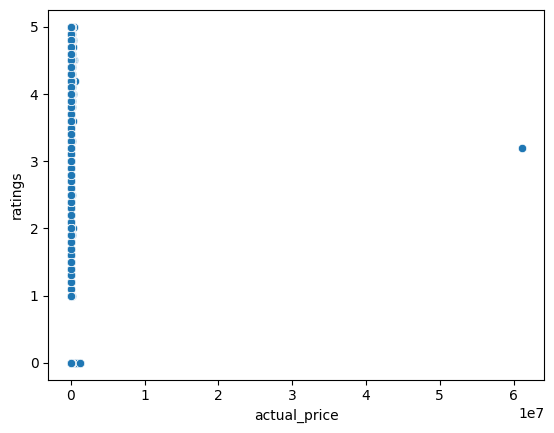

In [40]:
sns.scatterplot(data=combined_df, x='actual_price', y='ratings')

The plot was on 1e7 scale, the outlier isn't deleted because it's may contain useful insight. Now we make scatter plot with limit for high priced item, so we can see the price vs distribution

<Axes: title={'center': 'Scatterplot excluding high price item (>1e6)'}, xlabel='actual_price', ylabel='ratings'>

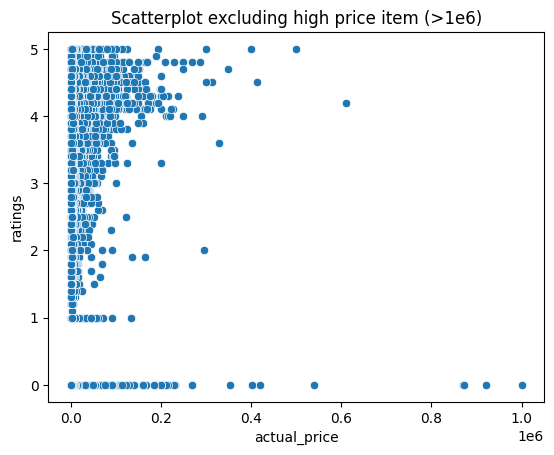

In [41]:
plt.title("Scatterplot excluding high price item (>1e6)")
sns.scatterplot(data=combined_df[combined_df['actual_price']<=1e6], x='actual_price', y='ratings')

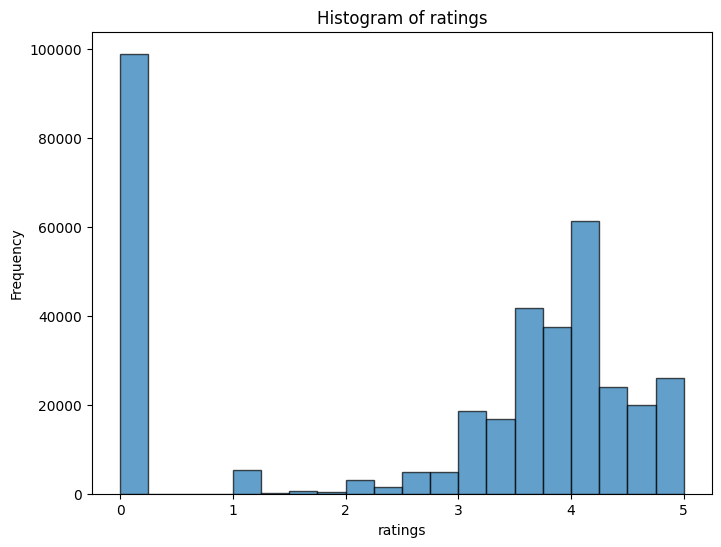

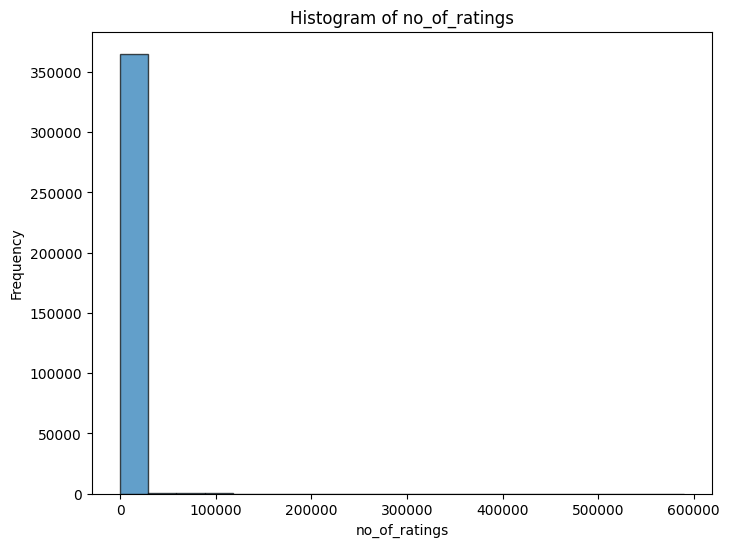

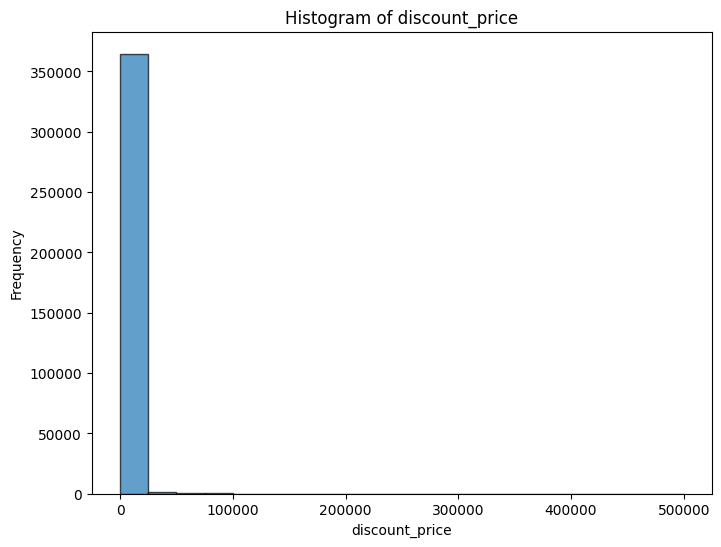

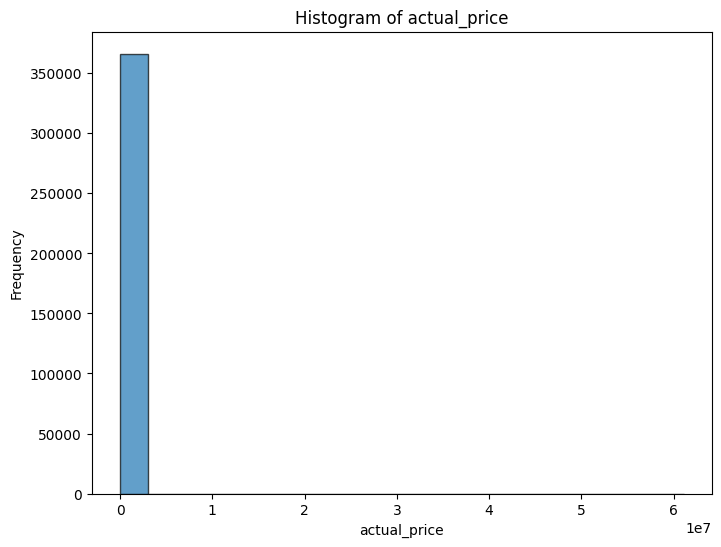

In [42]:
for col in combined_df[['ratings', 'no_of_ratings', 'discount_price', 'actual_price']]:
    plt.figure(figsize=(8, 6))
    plt.hist(combined_df[col].dropna(), bins=20, edgecolor='k', alpha=0.7)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


Analyze result:

- The histogram for `ratings`, has a significant peak at 0, indicating a large number of unrated products or default values. The majority of the rated products fall between 3 and 5, showing a skew towards higher ratings, which suggests that most customers rate products positively. The lower ratings (1 and 2) are relatively rare compared to higher ratings.
- The histogram for `no_of_ratings` shows a highly skewed distribution, where the majority of products have very few or zero ratings. A significant peak is observed near zero, indicating that most items in the dataset have not received substantial customer feedback. The presence of very few products with a large number of ratings creates a long tail, which suggests that only a small portion of items are highly popular and receive most of the attention.
- The histogram for `discount_price` shows an extremely skewed distribution, where the majority of products have very low or zero discount prices. The high peak near zero indicates that most items are either not discounted or have very small discount prices. A long tail is observed, representing a few items with significantly higher discount prices, suggesting that only a small number of products are heavily discounted.
- The histogram for `actual_price` shows a highly skewed distribution, where the majority of products have very low prices. A significant peak is observed near the lower end of the price range, indicating that most items are inexpensive. A long tail extends to the right, showing that a small number of products have extremely high prices, creating a clear imbalance in the dataset.

C:\Users\INTEL INSIDE\AppData\Local\Temp\ipykernel_26512\1815077079.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_df, x=combined_df[col], order=combined_df[col].value_counts().index, palette='viridis')


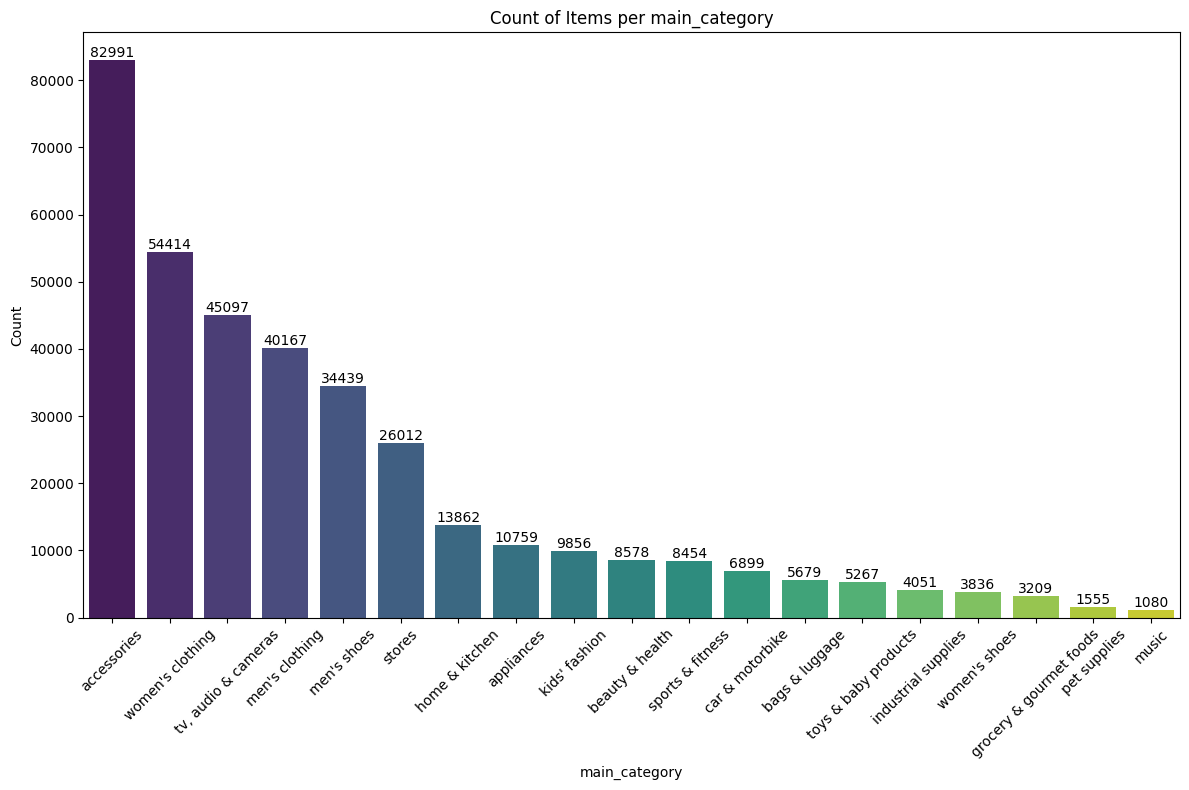

C:\Users\INTEL INSIDE\AppData\Local\Temp\ipykernel_26512\1815077079.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_df, x=combined_df[col], order=combined_df[col].value_counts().index, palette='viridis')


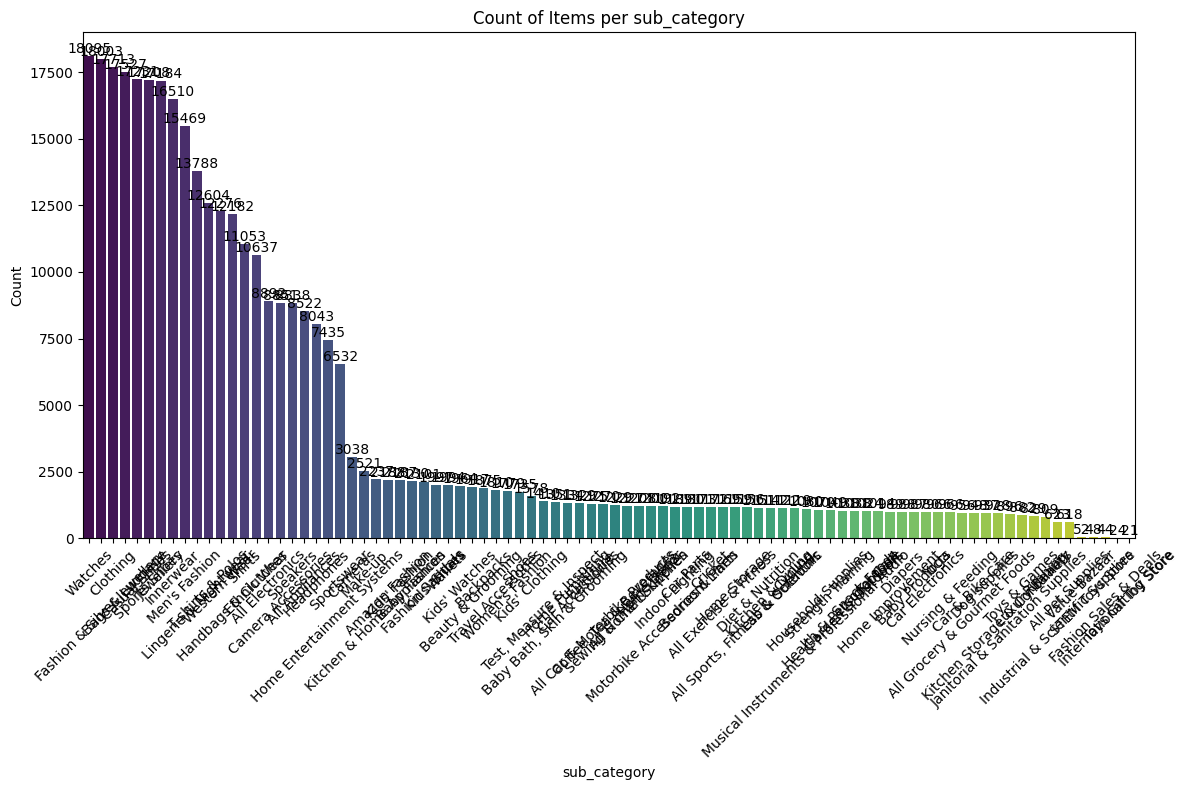

In [43]:
for col in ['main_category', 'sub_category']:
    plt.figure(figsize=(12, 8))
    counts=combined_df[col].value_counts()
    sns.countplot(data=combined_df, x=combined_df[col], order=combined_df[col].value_counts().index, palette='viridis')
    for index, value in enumerate(counts.values):
        plt.text(index, value, str(value), ha='center', va='bottom')
    plt.title(f'Count of Items per {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



More good `sub_category`:

C:\Users\INTEL INSIDE\AppData\Local\Temp\ipykernel_26512\2504772298.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_df, y='sub_category', order=combined_df['sub_category'].value_counts().index, palette='viridis')


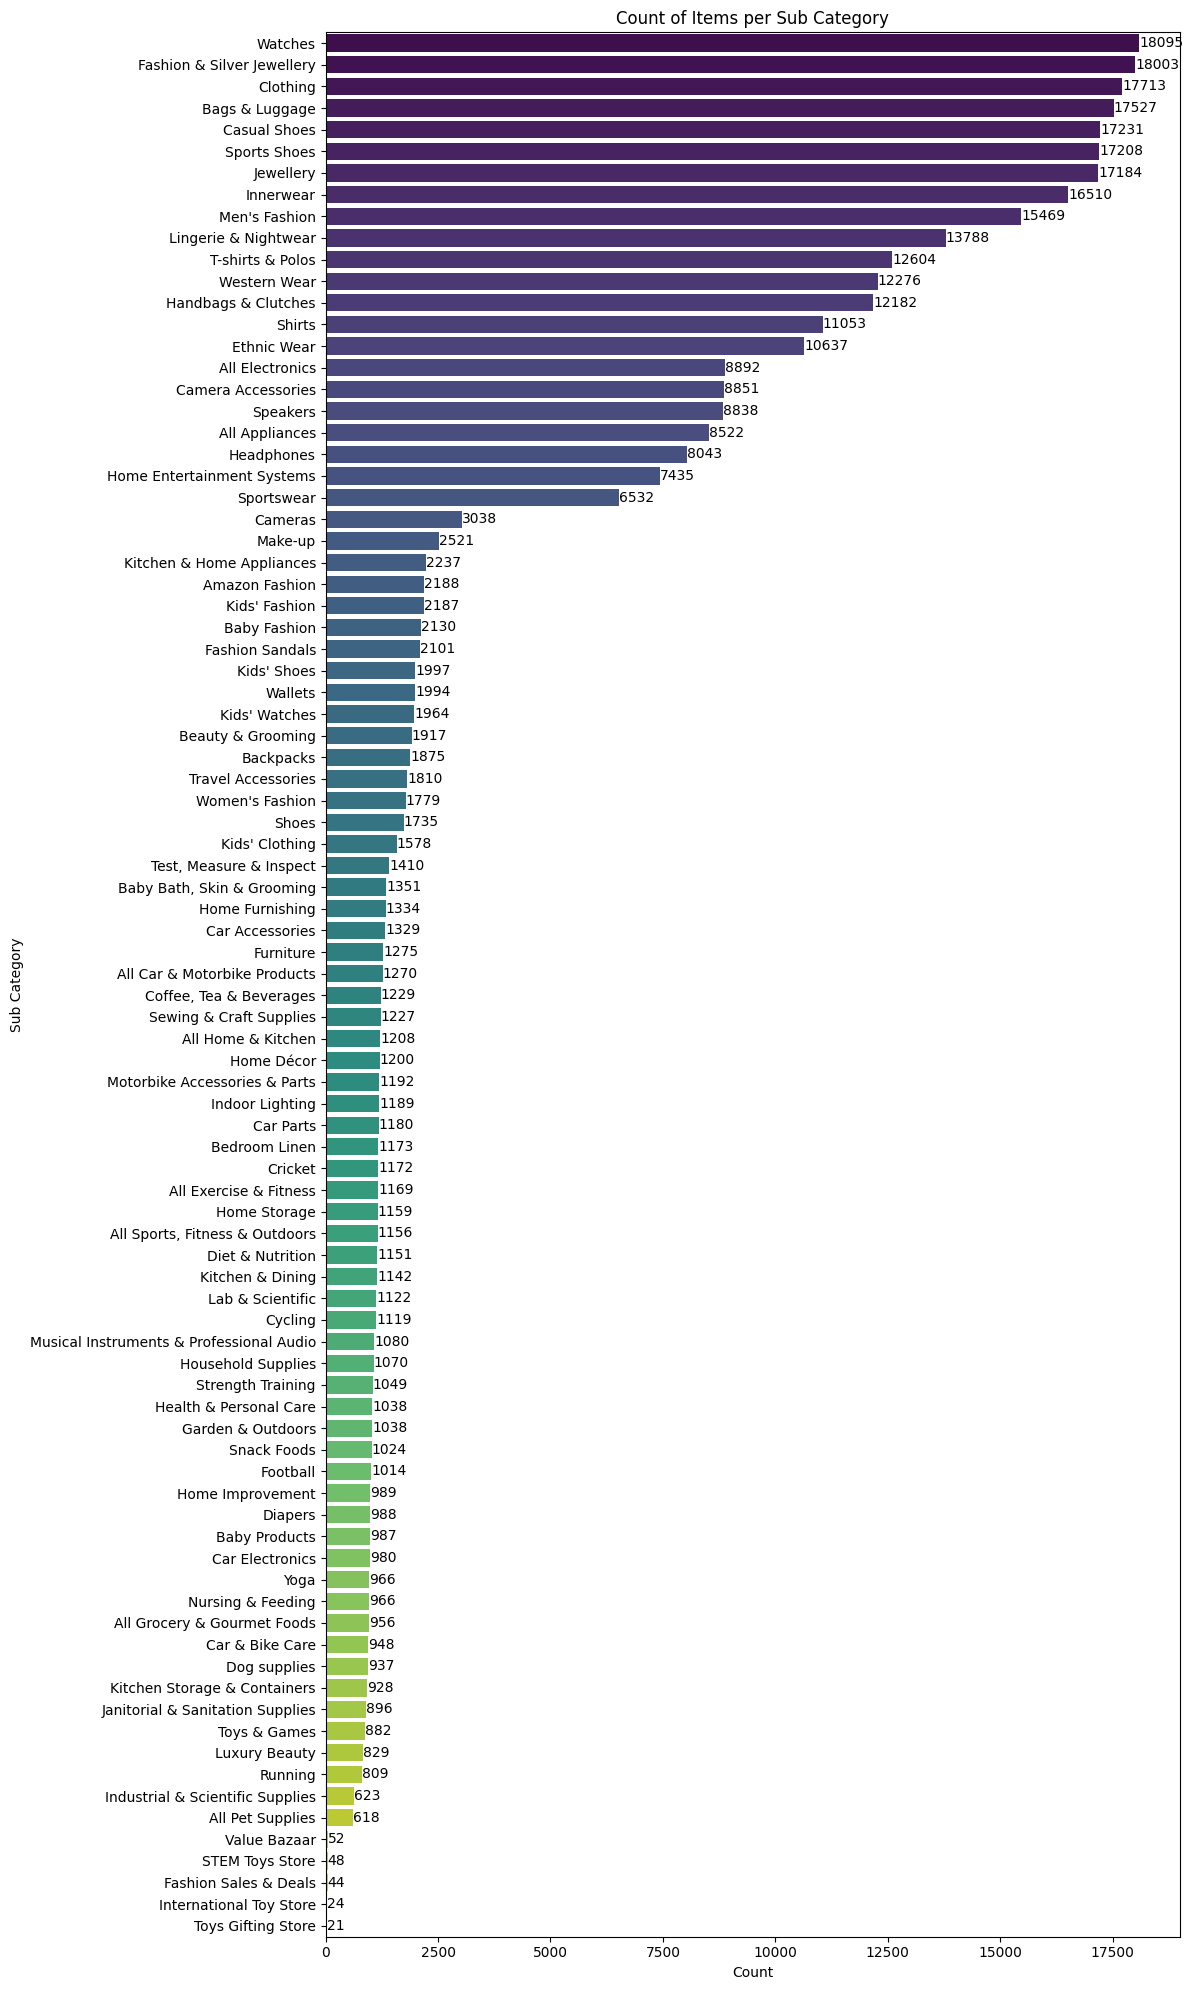

In [44]:
plt.figure(figsize=(12, 20))
counts=combined_df['sub_category'].value_counts()
sns.countplot(data=combined_df, y='sub_category', order=combined_df['sub_category'].value_counts().index, palette='viridis')

for index, value in enumerate(counts.values):
    plt.text(value, index, str(value), va='center')

plt.title('Count of Items per Sub Category')
plt.xlabel('Count')
plt.ylabel('Sub Category')
plt.tight_layout()
plt.show()

Analyze result:
- Based on the `main_category` barplot, the "Accessories" category has the highest number of items compared to other categories, indicating its dominance in the dataset. It is followed by categories such as "Women's Clothing", "TV, Audio & Cameras", and "Men's Clothing", each with a significant number of items. On the other hand, categories like "Music", "Pet Supplies", and "Grocery & Gourmet Foods" have the fewest items. This distribution suggests a focus on accessories and clothing products in the dataset, highlighting opportunities for deeper analysis of both popular and underrepresented categories.
- Based on the `sub_category` barplot, the "Watches" subcategory has the highest number of items, followed by "Fashion & Silver Jewellery", "Clothing", and "Bags & Luggage", which dominate the dataset. These subcategories likely represent popular or highly diverse product groups. On the other hand, subcategories such as "Toys Gifting Store", "Fashion Sales & Deals", and "STEM Toys Store" have the fewest items, suggesting either niche markets or less representation in the dataset. The distribution highlights the focus on lifestyle and fashion-related products, while indicating opportunities for further exploration in underrepresented subcategories.

Use pairplot to make it more easy

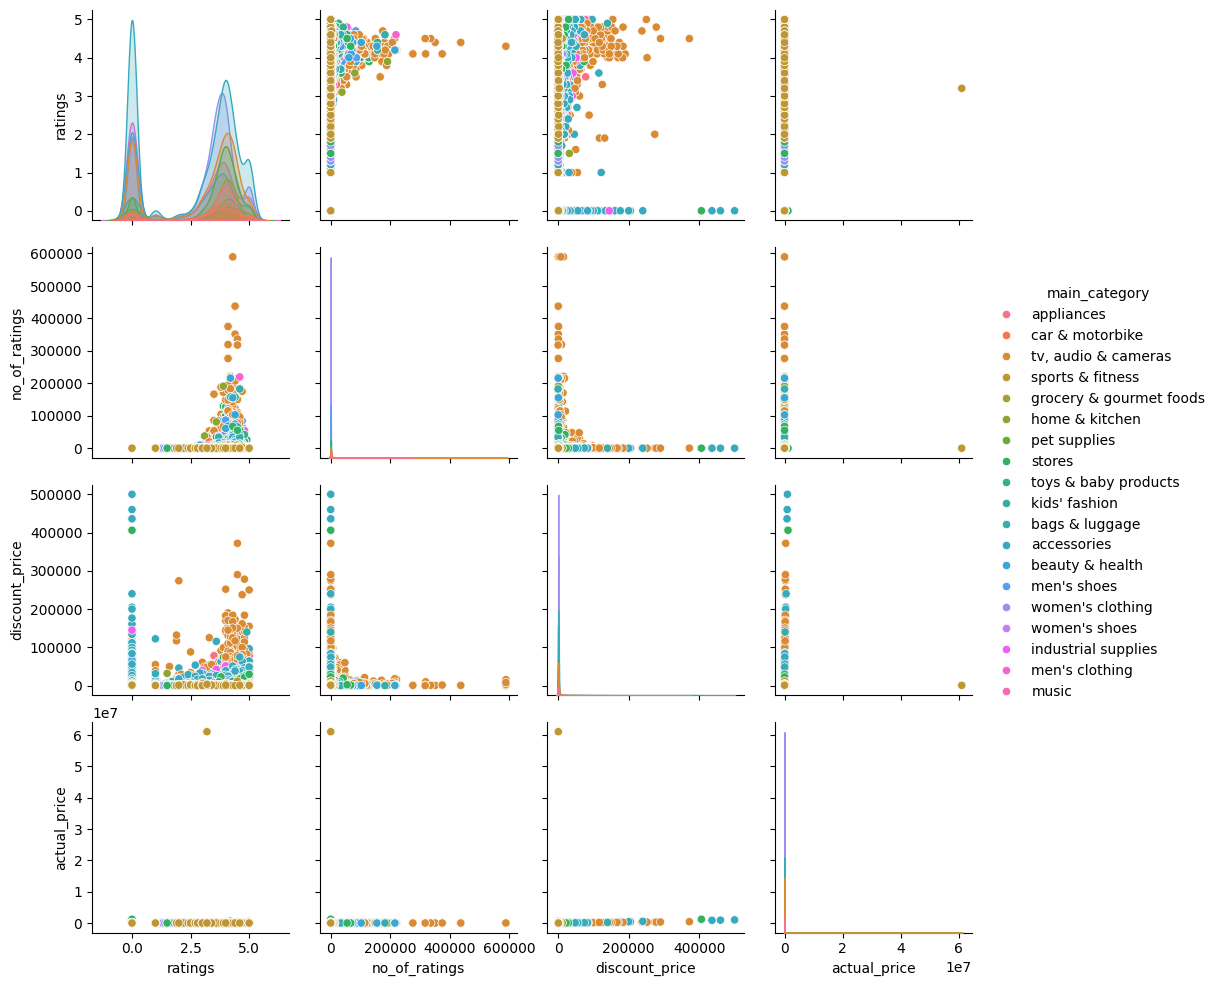

In [45]:
sns.pairplot(combined_df, vars=['ratings', 'no_of_ratings', 'discount_price', 'actual_price'], hue='main_category')
plt.show()

Wordcloud to make it easier to understand about the item listed

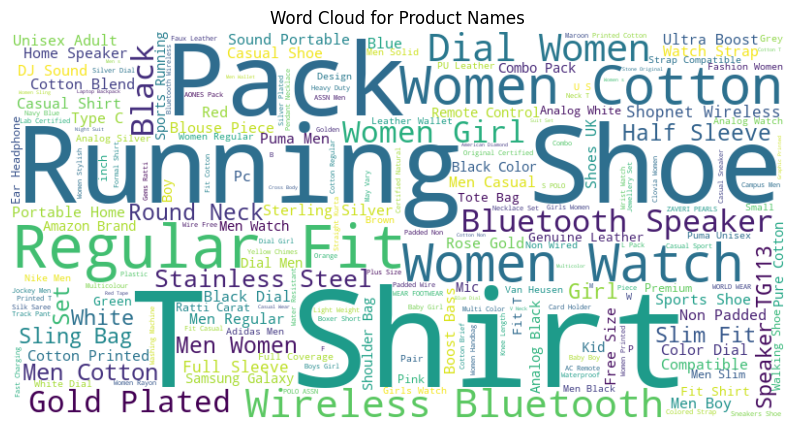

In [46]:
text = ' '.join(combined_df['name'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Product Names')
plt.show()

T-shirt and running shoes are the most listed item

C:\Users\INTEL INSIDE\AppData\Local\Temp\ipykernel_26512\1524507899.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=combined_df, x='main_category', y='ratings', palette='muted')


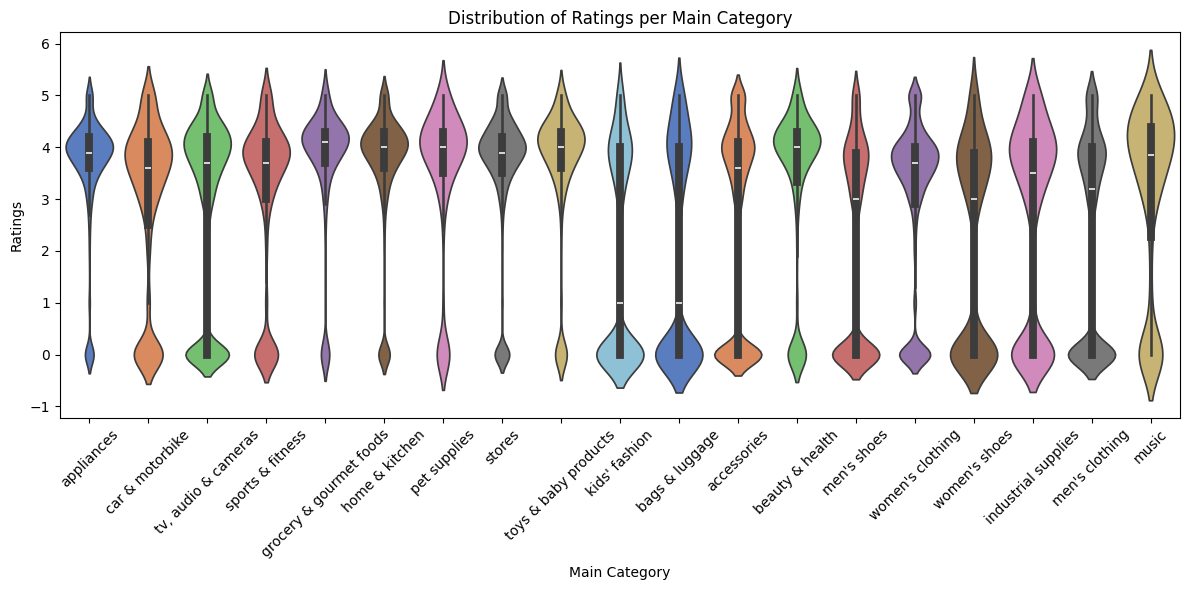

In [47]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=combined_df, x='main_category', y='ratings', palette='muted')
plt.title('Distribution of Ratings per Main Category')
plt.xlabel('Main Category')
plt.ylabel('Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Content-Based filtering

Combine important features such as `main_category`, `sub_category`, and `name` into one text column to create a unique description for each product.

In [48]:
df_content_based = combined_df.copy()
df_content_based['combined_features'] = df_content_based['main_category'] + ' ' + \
                                        df_content_based['sub_category'] + ' ' + \
                                        df_content_based['name']

In [49]:
df_content_based.head()

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,combined_features
720,"Pigeon by Stovekraft Amaze Plus Electric Kettle (14289) with Stainless Steel Body, 1.5 litre, used for boiling Water, maki...",appliances,All Appliances,3.9,128941.0,599.0,1245.0,"appliances All Appliances Pigeon by Stovekraft Amaze Plus Electric Kettle (14289) with Stainless Steel Body, 1.5 litre, used for boiling Water, maki..."
721,Pigeon Polypropylene Mini Handy and Compact Chopper with 3 Blades for Effortlessly Chopping Vegetables and Fruits for Your...,appliances,All Appliances,4.1,274505.0,199.0,545.0,appliances All Appliances Pigeon Polypropylene Mini Handy and Compact Chopper with 3 Blades for Effortlessly Chopping Vegetables and Fruits for Your...
722,Glun Multipurpose Portable Electronic Digital Weighing Scale Weight Machine (10 Kg - with Back Light),appliances,All Appliances,3.8,365.0,199.0,899.0,appliances All Appliances Glun Multipurpose Portable Electronic Digital Weighing Scale Weight Machine (10 Kg - with Back Light)
723,beatXP Kitchen Scale Multipurpose Portable Electronic Digital Weighing Scale | Weight Machine With Back light LCD Display...,appliances,All Appliances,3.7,3290.0,299.0,1999.0,appliances All Appliances beatXP Kitchen Scale Multipurpose Portable Electronic Digital Weighing Scale | Weight Machine With Back light LCD Display...
724,"Bajaj DX-6 1000W Dry Iron with Advance Soleplate and Anti-bacterial German Coating Technology, White",appliances,All Appliances,4.2,24380.0,625.0,1400.0,"appliances All Appliances Bajaj DX-6 1000W Dry Iron with Advance Soleplate and Anti-bacterial German Coating Technology, White"


In [50]:
df_content_based.shape

(366205, 8)

## Tokenize

In [51]:
df_content_based['tokenized_features'] = df_content_based['combined_features'].apply(lambda x: x.split())

In [52]:
all_tokens = [word for tokens in df_content_based['tokenized_features'] for word in tokens]
word_counts = Counter(all_tokens)

print(f"Most common words: {word_counts.most_common(10)}")
print(f"Total of word that only appears once: {len([word for word, count in word_counts.items() if count == 1])}")

Most common words: [('&', 243368), ('for', 119422), ('clothing', 94585), ('accessories', 83054), ("men's", 74666), ('with', 61434), ('Shoes', 61321), ("Men's", 60984), ("women's", 58812), ("Women's", 51712)]
Total of word that only appears once: 172191


We need to perform cleaning first

### Remove stopwords

In [53]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

df_content_based['cleaned_features'] = df_content_based['tokenized_features'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to C:\Users\INTEL
[nltk_data]     INSIDE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
df_content_based.head(1)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,combined_features,tokenized_features,cleaned_features
720,"Pigeon by Stovekraft Amaze Plus Electric Kettle (14289) with Stainless Steel Body, 1.5 litre, used for boiling Water, maki...",appliances,All Appliances,3.9,128941.0,599.0,1245.0,"appliances All Appliances Pigeon by Stovekraft Amaze Plus Electric Kettle (14289) with Stainless Steel Body, 1.5 litre, used for boiling Water, maki...","[appliances, All, Appliances, Pigeon, by, Stovekraft, Amaze, Plus, Electric, Kettle, (14289), with, Stainless, Steel, Body,, 1.5, litre,, used, for, boiling, Water,, maki...]","[appliances, Appliances, Pigeon, Stovekraft, Amaze, Plus, Electric, Kettle, (14289), Stainless, Steel, Body,, 1.5, litre,, used, boiling, Water,, maki...]"


### Lower the text

In [55]:
df_content_based['cleaned_features'] = df_content_based['cleaned_features'].apply(
    lambda tokens: [word.lower() for word in tokens]
)
df_content_based.head(1)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,combined_features,tokenized_features,cleaned_features
720,"Pigeon by Stovekraft Amaze Plus Electric Kettle (14289) with Stainless Steel Body, 1.5 litre, used for boiling Water, maki...",appliances,All Appliances,3.9,128941.0,599.0,1245.0,"appliances All Appliances Pigeon by Stovekraft Amaze Plus Electric Kettle (14289) with Stainless Steel Body, 1.5 litre, used for boiling Water, maki...","[appliances, All, Appliances, Pigeon, by, Stovekraft, Amaze, Plus, Electric, Kettle, (14289), with, Stainless, Steel, Body,, 1.5, litre,, used, for, boiling, Water,, maki...]","[appliances, appliances, pigeon, stovekraft, amaze, plus, electric, kettle, (14289), stainless, steel, body,, 1.5, litre,, used, boiling, water,, maki...]"


### Remove punctuations

In [56]:
df_content_based['cleaned_features'] = df_content_based['cleaned_features'].apply(
    lambda tokens: [re.sub(r'[^\w\s]', '', word) for word in tokens if re.sub(r'[^\w\s]', '', word)]
)
df_content_based.head(1)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,combined_features,tokenized_features,cleaned_features
720,"Pigeon by Stovekraft Amaze Plus Electric Kettle (14289) with Stainless Steel Body, 1.5 litre, used for boiling Water, maki...",appliances,All Appliances,3.9,128941.0,599.0,1245.0,"appliances All Appliances Pigeon by Stovekraft Amaze Plus Electric Kettle (14289) with Stainless Steel Body, 1.5 litre, used for boiling Water, maki...","[appliances, All, Appliances, Pigeon, by, Stovekraft, Amaze, Plus, Electric, Kettle, (14289), with, Stainless, Steel, Body,, 1.5, litre,, used, for, boiling, Water,, maki...]","[appliances, appliances, pigeon, stovekraft, amaze, plus, electric, kettle, 14289, stainless, steel, body, 15, litre, used, boiling, water, maki]"


### Lemmatization 

In [57]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to C:\Users\INTEL
[nltk_data]     INSIDE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [58]:
df_content_based['cleaned_features'] = df_content_based['cleaned_features'].apply(
    lambda tokens: [lemmatizer.lemmatize(word) for word in tokens]
)
df_content_based.head(1)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,combined_features,tokenized_features,cleaned_features
720,"Pigeon by Stovekraft Amaze Plus Electric Kettle (14289) with Stainless Steel Body, 1.5 litre, used for boiling Water, maki...",appliances,All Appliances,3.9,128941.0,599.0,1245.0,"appliances All Appliances Pigeon by Stovekraft Amaze Plus Electric Kettle (14289) with Stainless Steel Body, 1.5 litre, used for boiling Water, maki...","[appliances, All, Appliances, Pigeon, by, Stovekraft, Amaze, Plus, Electric, Kettle, (14289), with, Stainless, Steel, Body,, 1.5, litre,, used, for, boiling, Water,, maki...]","[appliance, appliance, pigeon, stovekraft, amaze, plus, electric, kettle, 14289, stainless, steel, body, 15, litre, used, boiling, water, maki]"


### Re check

In [59]:
all_tokens = [word for tokens in df_content_based['cleaned_features'] for word in tokens]
word_counts = Counter(all_tokens)

print(f"Most common words: {word_counts.most_common(10)}")
print(f"Total of word that only appears once: {len([word for word, count in word_counts.items() if count == 1])}")

Most common words: [('men', 194240), ('womens', 117353), ('clothing', 114458), ('shoe', 110752), ('accessory', 98547), ('fashion', 63557), ('camera', 63462), ('woman', 52090), ('bag', 49819), ('audio', 49291)]
Total of word that only appears once: 121575


Seems really good. We will use FastText for vectorization

## FastText model

In [60]:
fasttext_model = FastText(
    sentences=df_content_based['cleaned_features'],
    vector_size=100,
    window=5,
    min_count=5,
    workers=12,
    sg=1
)

fasttext_model.save("fasttext_model")

## Helper Function

In [61]:
# Vectorize text
def vectorize_text(text, model, vector_size=100):
    """
    Calculate the average FastText embedding for the given text.

    Args:
        text (str): The text whose embedding will be extracted.
        model (FastText): The pre-trained FastText model.
        vector_size (int): The dimension of the embeddings.

    Returns:
        np.ndarray: The average embedding vector for the text.

    """
    tokens = text.split()
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Sparse similarity
def compute_sparse_similarity(embeddings: np.ndarray, threshold: float = None) -> csr_matrix:
    """
    Computes a sparse cosine similarity matrix with or without a threshold.

    Args:
        embeddings (np.ndarray): Array of embeddings.
        threshold (float, optional): Similarity threshold to filter results. If None, all similarities are kept.

    Returns:
        csr_matrix: A sparse similarity matrix.
    """
    n = len(embeddings)
    sparse_similarity = []
    for i in tqdm(range(n), desc="Computing Sparse Similarity"):
        # Compute cosine similarity for row i
        row_sim = cosine_similarity([embeddings[i]], embeddings)[0]
        
        # If threshold is provided, filter results; otherwise, keep all
        if threshold is not None:
            sparse_row = [(j, sim) for j, sim in enumerate(row_sim) if sim >= threshold and i != j]
        else:
            sparse_row = [(j, sim) for j, sim in enumerate(row_sim) if i != j]  # Exclude self-similarity
        
        sparse_similarity.extend([(i, j, sim) for j, sim in sparse_row])
    
    # Convert to sparse matrix format
    if sparse_similarity:
        rows, cols, data = zip(*sparse_similarity)
        sparse_matrix = csr_matrix((data, (rows, cols)), shape=(n, n))
    else:
        sparse_matrix = csr_matrix((n, n))  # Empty matrix if no similarities are found
    return sparse_matrix


def recommend_products(
    product_index: int,
    similarity_matrix: csr_matrix,
    df: pd.DataFrame,
    top_n: int = 5
) -> pd.DataFrame:
    """
    Generates product recommendations based on a similarity matrix.

    Args:
        product_index (int): Index of the product to base recommendations on.
        similarity_matrix (csr_matrix): A sparse cosine similarity matrix.
        df (pd.DataFrame): The original DataFrame containing product metadata.
        top_n (int, optional): Number of recommendations to generate. Defaults to 5.

    Returns:
        pd.DataFrame: DataFrame containing recommended products with relevant details.
    """
    # Get similarity scores for the product
    sim_scores = similarity_matrix[product_index].toarray().flatten()
    
    # Exclude the product itself and sort by similarity
    top_indices = sim_scores.argsort()[::-1][1:top_n+1]  # Exclude self-similarity
    
    # Fetch the recommended products
    recommendations = df.iloc[top_indices][['name', 'main_category', 'sub_category', 'ratings']]
    recommendations['similarity_score'] = sim_scores[top_indices]
    
    return recommendations


def precision_recall(
    ground_truth: list,
    recommendations: pd.DataFrame
) -> dict:
    """
    Calculates precision and recall for recommendations.

    Args:
        ground_truth (list): List of true relevant product IDs.
        recommendations (pd.DataFrame): DataFrame of recommended product IDs.

    Returns:
        dict: Precision and recall scores.
    """
    recommended_ids = recommendations.index.tolist()
    relevant_and_recommended = len(set(recommended_ids) & set(ground_truth))
    precision = relevant_and_recommended / len(recommended_ids) if recommended_ids else 0
    recall = relevant_and_recommended / len(ground_truth) if ground_truth else 0
    
    return {"precision": precision, "recall": recall}

def recommendation_pipeline(
    product_index: int,
    similarity_matrix: csr_matrix,
    df: pd.DataFrame,
    ground_truth: list = None,
    top_n: int = 5
):
    """
    Full pipeline for generating and evaluating recommendations.

    Args:
        product_index (int): Index of the product to base recommendations on.
        similarity_matrix (csr_matrix): A sparse cosine similarity matrix.
        df (pd.DataFrame): The original DataFrame containing product metadata.
        ground_truth (list, optional): List of true relevant product IDs for evaluation. Defaults to None.
        top_n (int, optional): Number of recommendations to generate. Defaults to 5.

    Returns:
        None: Prints recommendations and evaluation metrics.
    """
    # Step 1: Display selected product
    print("Selected Product:")
    print(df.iloc[product_index][['name', 'main_category', 'sub_category']])
    
    # Step 2: Generate recommendations
    recommendations = recommend_products(product_index, similarity_matrix, df, top_n)
    print("\nRecommendations:")
    print(recommendations)
    
    # Step 3: Evaluate recommendations
    if ground_truth:
        metrics = precision_recall(ground_truth, recommendations)
        print("\nEvaluation Metrics:")
        print(f"Precision: {metrics['precision']:.2f}")
        print(f"Recall: {metrics['recall']:.2f}")


## Vectorization

In [62]:
df_content_based['fasttext_embedding'] = df_content_based['cleaned_features'].apply(
    lambda x: vectorize_text(" ".join(x), fasttext_model)
)
df_content_based.head(1)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,combined_features,tokenized_features,cleaned_features,fasttext_embedding
720,"Pigeon by Stovekraft Amaze Plus Electric Kettle (14289) with Stainless Steel Body, 1.5 litre, used for boiling Water, maki...",appliances,All Appliances,3.9,128941.0,599.0,1245.0,"appliances All Appliances Pigeon by Stovekraft Amaze Plus Electric Kettle (14289) with Stainless Steel Body, 1.5 litre, used for boiling Water, maki...","[appliances, All, Appliances, Pigeon, by, Stovekraft, Amaze, Plus, Electric, Kettle, (14289), with, Stainless, Steel, Body,, 1.5, litre,, used, for, boiling, Water,, maki...]","[appliance, appliance, pigeon, stovekraft, amaze, plus, electric, kettle, 14289, stainless, steel, body, 15, litre, used, boiling, water, maki]","[-0.07731932, 0.055355992, -0.02850912, -0.04711818, 0.4187461, -0.10287823, -0.50258714, 0.31273276, 0.024768434, -0.47328725, -0.54419845, 0.30632526, 0.40330833, 0.32146603, 0.4448808, -0.3242358, -0.00091337576, -0.34383893, 0.0019126832, 0.2232242, 0.26347223, 0.09001808, -0.010248527, -0.39827982, -0.38492835, -0.4008571, -0.17744872, -0.07383222, 0.22078016, -0.12127221, -0.39037937, 0.0023520945, 0.16489172, -0.35405263, -0.0659922, 0.35982153, -0.018704684, 0.26517504, 0.06817814, 0.038382497, -0.46924073, -0.19109029, -0.11856271, -0.5108854, -0.36102617, -0.1965788, -0.352649, 0.10596516, -0.15724948, -0.32824492, -0.15005082, 0.25686866, 0.1310528, 0.20769803, -0.41345155, -0.24200232, -0.24041308, 0.12188089, -0.14206773, -0.0981525, 0.21738026, -0.47002712, -0.2552479, 0.20627348, 0.12397117, 0.11449972, 0.10767374, 0.36188254, 0.32768953, 0.02105669, -0.27432853, -0.1979181, 0.12763959, -0.02526791, -0.30614045, -0.16420534, -0.09004266, 0.21442743, 0.2455395, -0.19285256, -0.1140708, -0.30436856, -0.09242869, 0.08174744, 0.14513059, -0.04865849, -0.24747705, -0.27217433, 0.2801383, 0.5978337, 0.093727306, 0.40360206, -0.21211112, -0.06273188, 0.19608064, -0.2585342, -0.32499215, -0.2783728, -0.18494572, 0.32108504]"


## Embeddings matrix

In [63]:
embedding_matrix = np.stack(df_content_based['fasttext_embedding'].values)
np.save('fasttext_embeddings.npy', embedding_matrix)

print(f"Embedding Matrix Shape: {embedding_matrix.shape}")

Embedding Matrix Shape: (366205, 100)


## Similarity

Due to the large dataset and the occurrence of a "memory runs out" error, we decided to randomly reduce the dataset to 10,000 rows.

In [64]:
# Reduced df
reduced_df_content_based = df_content_based.sample(n=10000, random_state=42).reset_index(drop=True)

print(f"Original dataset size: {df_content_based.shape}")
print(f"Reduced dataset size: {reduced_df_content_based.shape}")

Original dataset size: (366205, 11)
Reduced dataset size: (10000, 11)


Save to CSV

In [65]:
# reduced_df_content_based.to_csv("pruned amazon product (embeddings).csv", index=False)

In [66]:
# model for reduced df
reduced_fasttext_model = FastText(
    sentences=reduced_df_content_based['cleaned_features'],
    vector_size=100,
    window=5,
    min_count=5,
    workers=12,
    sg=1
)

fasttext_model.save("reduced_fasttext_model")

In [67]:
reduced_embedding_matrix = np.stack(reduced_df_content_based['fasttext_embedding'].values)

In [68]:
print("Original Distribution:")
print(df_content_based['main_category'].value_counts(normalize=True))
print("\n")
print("Reduced Distribution:")
print(reduced_df_content_based['main_category'].value_counts(normalize=True))

Original Distribution:
main_category
accessories                0.226624
women's clothing           0.148589
tv, audio & cameras        0.123147
men's clothing             0.109684
men's shoes                0.094043
stores                     0.071031
home & kitchen             0.037853
appliances                 0.029380
kids' fashion              0.026914
beauty & health            0.023424
sports & fitness           0.023085
car & motorbike            0.018839
bags & luggage             0.015508
toys & baby products       0.014383
industrial supplies        0.011062
women's shoes              0.010475
grocery & gourmet foods    0.008763
pet supplies               0.004246
music                      0.002949
Name: proportion, dtype: float64


Reduced Distribution:
main_category
accessories                0.2333
women's clothing           0.1428
tv, audio & cameras        0.1237
men's clothing             0.1075
men's shoes                0.0958
stores                     0.0709
home

In [69]:
reduced_df_content_based.head(1)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,combined_features,tokenized_features,cleaned_features,fasttext_embedding
0,WORLD WEAR FOOTWEAR Men's (Combo-(2AMZ)-5011-1242) Multicolor Sport Sneakers Running Shoes 9 UK,men's shoes,Sports Shoes,0.0,0.0,949.0,999.0,men's shoes Sports Shoes WORLD WEAR FOOTWEAR Men's (Combo-(2AMZ)-5011-1242) Multicolor Sport Sneakers Running Shoes 9 UK,"[men's, shoes, Sports, Shoes, WORLD, WEAR, FOOTWEAR, Men's, (Combo-(2AMZ)-5011-1242), Multicolor, Sport, Sneakers, Running, Shoes, 9, UK]","[men, shoe, sport, shoe, world, wear, footwear, men, combo2amz50111242, multicolor, sport, sneaker, running, shoe, 9, uk]","[-0.9515141, 0.21248549, 0.14186543, -0.43010384, -0.07752004, -0.25287053, 0.3822397, -0.03999037, -0.082521155, 0.26608512, -0.5527442, -0.0005235784, 0.11052957, 0.29375717, 0.17873971, -0.5606102, 0.33330935, -0.20240588, 0.10699671, 0.118647575, 0.1942012, -0.052912053, -0.5399592, 0.35646078, 0.25543803, 0.013912033, -0.24452254, 0.2836108, -0.18759602, -0.4168336, -0.33603278, 0.6063917, 0.1537794, 0.33307186, 0.2164698, 0.594039, -0.11954061, 0.16344994, 0.16002832, -0.10382533, 0.074041754, 0.44150192, -0.21865228, -0.16254354, -0.5092219, 0.2755355, -0.3747221, -0.22348051, -0.32419348, 0.22747964, 0.31574503, 0.51675034, -0.30883983, 0.104386464, 0.08080833, -0.121911444, -0.19008096, -0.31056565, 0.24859992, 0.5429572, 0.4487289, 0.08528682, 0.13950752, 0.06336221, 0.46980867, -0.26464343, -0.2583286, 0.1148501, 0.059578396, 0.1759845, -0.26963326, 0.038923357, 0.49583292, 0.2129491, -0.04826746, -0.06784881, 0.14682537, -0.28259045, 0.5235143, -0.3990317, 0.04769478, -0.44615358, 0.3785053, -0.23599023, 0.016412757, 0.02662968, -0.18587743, 0.69700885, 0.31486335, 0.17145705, 0.5935123, 0.61594284, 0.25739908, -0.41575018, 0.018095765, -0.5222524, -0.6396779, 0.087321065, -0.49231613, -0.31685823]"


In [72]:
sparse_similarity_matrix = compute_sparse_similarity(reduced_embedding_matrix, threshold=0.7)

Computing Sparse Similarity: 100%|██████████| 10000/10000 [02:20<00:00, 71.18it/s]


In [71]:
# save_npz("sparse_similarity_matrix.npz", sparse_similarity_matrix)
# print("Sparse similarity matrix saved successfully.")

In [69]:
sparse_similarity_matrix = load_npz("sparse_similarity_matrix.npz")
print("Sparse similarity matrix loaded successfully.")

Sparse similarity matrix loaded successfully.


## Evaluation

In [71]:
product_index = 250  # The index of the selected items
recommendation_pipeline(product_index, sparse_similarity_matrix, reduced_df_content_based, top_n=5)

Selected Product:
name             AB Beauty House Gold Plated Bracelet Bangles With RED Set for Women and Girls 2pcs 2.8
main_category                                                                               accessories
sub_category                                                                 Fashion & Silver Jewellery
Name: 250, dtype: object

Recommendations:
                                                                                                                               name  \
140                               BEAUTY BURST Plastic Gold Plated White Coloured Shakha Pola Bangle Set for women pack of 2 pieces   
5084  Shining priya 1 Gram Gold Plated Nelli Traditional Vangi Bangle Thick Size Daily Wearable Bangles for Women - Set of 4 Ban...   
3339                     YouBella Jewellery Combo of 6 Gold Plated Earrings for Girls and Women (Multi-Color) (YBEAR_32937), Medium   
9469      I Jewels 18K Gorgeous Traditional Multi Color Plain Metal Velvet Chuda Bangle

Ground Truth Evaluation

In [72]:
ground_truth = [250, 140, 5084, 3339, 9469, 1807]  # Product index
recommendation_pipeline(product_index, sparse_similarity_matrix, reduced_df_content_based, ground_truth=ground_truth, top_n=5)

Selected Product:
name             AB Beauty House Gold Plated Bracelet Bangles With RED Set for Women and Girls 2pcs 2.8
main_category                                                                               accessories
sub_category                                                                 Fashion & Silver Jewellery
Name: 250, dtype: object

Recommendations:
                                                                                                                               name  \
140                               BEAUTY BURST Plastic Gold Plated White Coloured Shakha Pola Bangle Set for women pack of 2 pieces   
5084  Shining priya 1 Gram Gold Plated Nelli Traditional Vangi Bangle Thick Size Daily Wearable Bangles for Women - Set of 4 Ban...   
3339                     YouBella Jewellery Combo of 6 Gold Plated Earrings for Girls and Women (Multi-Color) (YBEAR_32937), Medium   
9469      I Jewels 18K Gorgeous Traditional Multi Color Plain Metal Velvet Chuda Bangle

Content-based filtering produced excellent results. An experiment on the item with index 250 yielded outcomes that were highly relevant to the selected item. Testing with ground truth, using the same items and recommendation results, achieved a precision of 100% and a recall of 83%.

# Collaborative filtering

We decided to use the same sample dataframe as content-based due to the memory allocation error (Unable to allocate 832. GiB)

In [101]:
df_colaborative = reduced_df_content_based.copy()
df_colaborative.drop(columns=['combined_features','tokenized_features', 'cleaned_features', 'fasttext_embedding'], inplace=True)
df_colaborative.head()

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
0,WORLD WEAR FOOTWEAR Men's (Combo-(2AMZ)-5011-1242) Multicolor Sport Sneakers Running Shoes 9 UK,men's shoes,Sports Shoes,0.0,0.0,949.0,999.0
1,"Triquip BeVisible Men's Cycling Jersey Half Sleeves with 3 Rear Cargo Pockets and 1 Zipped Water Proof Pocket, Breathable,...",men's clothing,T-shirts & Polos,4.5,2.0,999.0,1999.0
2,Gemorio Citrine Sunehla 6.5cts or 7.25ratti Panchdhatu Adjustable Ring for Men,accessories,Jewellery,2.8,15.0,1899.0,3798.0
3,AVINA Tissue Fabric Premium Casual Top for Women's,women's clothing,Western Wear,3.4,43.0,389.0,1599.0
4,WORLD WEAR FOOTWEAR Men's (Combo-(2AMZ)-9437-9444) Multicolor Sport Sneakers Running Shoes 7 UK,men's shoes,Sports Shoes,0.0,0.0,989.0,999.0


In [102]:
print(f"Dataset size: {df_colaborative.shape}")

Dataset size: (10000, 7)


Since the dataset has no explicit user data, create a simulation column for Collaborative Filtering.

In [103]:
df_colaborative['user'] = np.random.randint(1, 1000, size=len(df_colaborative))  # 1000 user simulation
df_colaborative.head(1)

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,user
0,WORLD WEAR FOOTWEAR Men's (Combo-(2AMZ)-5011-1242) Multicolor Sport Sneakers Running Shoes 9 UK,men's shoes,Sports Shoes,0.0,0.0,949.0,999.0,678


## Helper functions

In [104]:
def recommend_products_collab(product_name: str, similarity_df: pd.DataFrame, top_n: int = 5):
    """
    Product recommendation based on Collaborative Filtering (item-based).

    Args:
        product_name (str): Name of the product to base recommendations on.
        similarity_df (pd.DataFrame): DataFrame containing product similarity scores.
        top_n (int, optional): Number of recommendations to generate. Default: 5.

    Returns:
        pd.DataFrame: DataFrame containing recommended products and similarity scores.
    """
    if product_name not in similarity_df.index:
        print(f"Product '{product_name}' not found in similarity data.")
        return None
    
    # Get the most similar products based on score
    similar_products = similarity_df[product_name].sort_values(ascending=False).iloc[1:top_n+1]
    
    # Result format
    recommendations = pd.DataFrame({
        'product_name': similar_products.index,
        'similarity_score': similar_products.values
    })
    return recommendations

def clean_product_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the 'name' column in the DataFrame to ensure consistency.

    Cleaning steps:
    1. Remove stopwords.
    2. Convert text to lowercase.
    3. Remove punctuations.

    Args:
        df (pd.DataFrame): Input DataFrame containing a 'name' column.

    Returns:
        pd.DataFrame: DataFrame with cleaned 'name' column.
    """
    stop_words = set(stopwords.words('english'))
    
    def clean_text(text):
        if isinstance(text, str):
            # Lowercase
            text = text.lower()
            # Remove punctuations
            text = re.sub(r'[^\w\s]', '', text)
            # Remove stopwords
            text = ' '.join([word for word in text.split() if word not in stop_words])
        return text

    df['name'] = df['name'].apply(clean_text)
    return df

## Normalize the data

In [105]:
df_colaborative = clean_product_names(df_colaborative)
df_colaborative.head()

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,user
0,world wear footwear mens combo2amz50111242 multicolor sport sneakers running shoes 9 uk,men's shoes,Sports Shoes,0.0,0.0,949.0,999.0,678
1,triquip bevisible mens cycling jersey half sleeves 3 rear cargo pockets 1 zipped water proof pocket breathable,men's clothing,T-shirts & Polos,4.5,2.0,999.0,1999.0,310
2,gemorio citrine sunehla 65cts 725ratti panchdhatu adjustable ring men,accessories,Jewellery,2.8,15.0,1899.0,3798.0,897
3,avina tissue fabric premium casual top womens,women's clothing,Western Wear,3.4,43.0,389.0,1599.0,261
4,world wear footwear mens combo2amz94379444 multicolor sport sneakers running shoes 7 uk,men's shoes,Sports Shoes,0.0,0.0,989.0,999.0,577


In [106]:
df_colaborative.shape

(10000, 8)

Make a pivot table

In [108]:
pivot_table = df_colaborative.pivot_table(index='user', columns='name', values='ratings', fill_value=0)
pivot_table.head()

name,1 4 hd 1080p 3d 14 hdmi splitter duplicator amplifier switch ac adapter black,1 mukhi nepal rudraksha lab certified,1 stop fashion womens multi coloured digital print crepe kurtaskurtispack 6,10 grams 999 wedding anniverseryengagementcouple gift silver coin bis hallmarked,10 mukhi rudraksha bracelet 10 face rudraksha bracelet lab certified export quality natural,10 pcs gota polka potli pouches colorful gifts jewellery chocolates shagun party diy craft work,100k ohm 3590s precision multiturn potentiometer,100kg pocket balance double spring balance attach ring hook,100yellow buddha design luggage tags bag tag travel id labels tag baggage suitcases bags silicon ideal travel,100yellow designer luggage tags bag tag travel id labels tag baggage suitcases bags silicon ideal,...,zuperb lingerie womens wirefree non padded cotton tshirt bra,zuperia luxury mesh magnet buckle quartz watches girls women,zuriel waterproof hands free portable foldabl umbrella rain hat headwear cap cute rain coat cover children umbrella hat,zuvairiya store womens front open zipper poly cotton padded sports bra nonwired removable pads,zuvino maternity dresses women nursing kurtis zip women feeding dresses women maternity nursing kur,zwab womens banarasi kanjivaram pure zari soft silk traditional lehenga saree unstitched lehenga choli half saree,zxn clothing women plus size tummy tucker high waist stretchable denim scratch jegging jeans,zybux iphone 14 iphone 14 plus metal rings back camera lens protector anti scratch hd tempered metal glass back came,नshire nishire womens pure cotton printed straight kurta pant dupatta set,पदनम khadi cargo pants
user,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
pivot_table.shape

(999, 9937)

In [110]:
pivot_table.T

user,1,2,3,4,5,6,7,8,9,10,...,990,991,992,993,994,995,996,997,998,999
name,,,,,,,,,,,,,,,,,,,,,
1 4 hd 1080p 3d 14 hdmi splitter duplicator amplifier switch ac adapter black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1 mukhi nepal rudraksha lab certified,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1 stop fashion womens multi coloured digital print crepe kurtaskurtispack 6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 grams 999 wedding anniverseryengagementcouple gift silver coin bis hallmarked,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 mukhi rudraksha bracelet 10 face rudraksha bracelet lab certified export quality natural,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwab womens banarasi kanjivaram pure zari soft silk traditional lehenga saree unstitched lehenga choli half saree,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zxn clothing women plus size tummy tucker high waist stretchable denim scratch jegging jeans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zybux iphone 14 iphone 14 plus metal rings back camera lens protector anti scratch hd tempered metal glass back came,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Similarity of each product

In [111]:
# Transpose pivot table for item-based similarity calculation
product_matrix = csr_matrix(pivot_table.T)

# Calculate cosine similarity between products
product_similarity = cosine_similarity(product_matrix)

# Convert to DataFrame to make analysis easier
product_similarity_df = pd.DataFrame(
    product_similarity,
    index=pivot_table.columns,
    columns=pivot_table.columns
)

In [112]:
product_similarity_df.head(1)

name,1 4 hd 1080p 3d 14 hdmi splitter duplicator amplifier switch ac adapter black,1 mukhi nepal rudraksha lab certified,1 stop fashion womens multi coloured digital print crepe kurtaskurtispack 6,10 grams 999 wedding anniverseryengagementcouple gift silver coin bis hallmarked,10 mukhi rudraksha bracelet 10 face rudraksha bracelet lab certified export quality natural,10 pcs gota polka potli pouches colorful gifts jewellery chocolates shagun party diy craft work,100k ohm 3590s precision multiturn potentiometer,100kg pocket balance double spring balance attach ring hook,100yellow buddha design luggage tags bag tag travel id labels tag baggage suitcases bags silicon ideal travel,100yellow designer luggage tags bag tag travel id labels tag baggage suitcases bags silicon ideal,...,zuperb lingerie womens wirefree non padded cotton tshirt bra,zuperia luxury mesh magnet buckle quartz watches girls women,zuriel waterproof hands free portable foldabl umbrella rain hat headwear cap cute rain coat cover children umbrella hat,zuvairiya store womens front open zipper poly cotton padded sports bra nonwired removable pads,zuvino maternity dresses women nursing kurtis zip women feeding dresses women maternity nursing kur,zwab womens banarasi kanjivaram pure zari soft silk traditional lehenga saree unstitched lehenga choli half saree,zxn clothing women plus size tummy tucker high waist stretchable denim scratch jegging jeans,zybux iphone 14 iphone 14 plus metal rings back camera lens protector anti scratch hd tempered metal glass back came,नshire nishire womens pure cotton printed straight kurta pant dupatta set,पदनम khadi cargo pants
name,,,,,,,,,,,,,,,,,,,,,
1 4 hd 1080p 3d 14 hdmi splitter duplicator amplifier switch ac adapter black,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Evaluation

In [ ]:
df_colaborative[df_colaborative['name'].str.contains("Gold Plated Bracelet Bangles", case=False, na=False)]

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,user
250,ab beauty house gold plated bracelet bangles red set women girls 2pcs 28,accessories,Fashion & Silver Jewellery,0.0,0.0,399.0,599.0,360


In [125]:
# Select a product for recommendations
product_name = "ab beauty house gold plated bracelet bangles red set women girls 2pcs 28"

# Get recommendations
recommendations = recommend_products_collab(product_name, product_similarity_df, top_n=5)

# Show recommended results
if recommendations is not None:
    print("Recommendations:")
    print(recommendations)

Recommendations:
                                                                                                        product_name  \
0                                                                                          pro khadims mens sneakers   
1  priyanshu navratn men womens lab certified 800 ratti 720 carat natural cats eye cabochune lahsuniya gemstone free   
2                                                                             pro ase professional cricket shoes men   
3                                                                pro gym inguinal hernia support brief gym supporter   
4                                                                         pro gym mens slim fit tshirt 1_black_large   

   similarity_score  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  


The Collaborative Filtering approach in this case delivers suboptimal results due to the absence of actual user features in the dataset, requiring the use of simulated users. In production scenarios, this approach is referred to as proxy data, where simulations substitute real data to attempt replicating user-product interaction patterns. However, without actual user data, the system cannot leverage authentic interaction patterns, resulting in less relevant recommendations. This issue is also linked to the cold start problem, where new products or users with no interaction history are difficult to recommend effectively. In Collaborative Filtering, user data is essential for uncovering relationships between users (user-based filtering) or between products (item-based filtering) based on interaction patterns. While Collaborative Filtering is conceptually simpler than Content-Based Filtering, as it does not require understanding product features such as names, categories, or descriptions, this simplicity becomes a drawback when user interaction data is unavailable or unrepresentative. To overcome these limitations, a Hybrid Filtering approach, which combines both Collaborative and Content-Based Filtering, will also be explored to improve recommendation accuracy and address cold start issues effectively.

# Hybrid fitlering

Hybrid filtering combine content-based and collaborative filtering

In [128]:
def hybrid_recommendation(
    product_index: int,
    similarity_matrix_cb: csr_matrix,
    df_cb: pd.DataFrame,
    product_name: str,
    similarity_df_cf: pd.DataFrame,
    content_weight: float = 0.5,
    collab_weight: float = 0.5,
    top_n: int = 5
) -> pd.DataFrame:
    """
    Hybrid Filtering that combines Content-Based and Collaborative Filtering.

    Args:
        product_index (int): Index of the product for Content-Based Filtering.
        similarity_matrix_cb (csr_matrix): Content-Based similarity matrix.
        df_cb (pd.DataFrame): DataFrame for Content-Based Filtering metadata.
        product_name (str): Name of the product for Collaborative Filtering.
        similarity_df_cf (pd.DataFrame): Collaborative Filtering similarity matrix.
        content_weight (float): Weight for Content-Based Filtering scores.
        collab_weight (float): Weight for Collaborative Filtering scores.
        top_n (int): Number of recommendations to generate.

    Returns:
        pd.DataFrame: DataFrame containing hybrid recommendations with scores.
    """
    # Content-Based Recommendations
    cb_recommendations = recommend_products(product_index, similarity_matrix_cb, df_cb, top_n=top_n*2)

    # Collaborative Recommendations
    cf_recommendations = recommend_products_collab(product_name, similarity_df_cf, top_n=top_n*2)

    if cb_recommendations is None or cf_recommendations is None:
        return None

    # Merge recommendations by product name
    hybrid_recommendations = pd.merge(
        cb_recommendations.rename(columns={'similarity_score': 'content_score'}),
        cf_recommendations.rename(columns={'similarity_score': 'collab_score'}),
        left_on='name', right_on='product_name',
        how='outer'
    ).fillna(0)

    # Compute hybrid score
    hybrid_recommendations['hybrid_score'] = (
        hybrid_recommendations['content_score'] * content_weight +
        hybrid_recommendations['collab_score'] * collab_weight
    )

    # Sort by hybrid score
    hybrid_recommendations = hybrid_recommendations.sort_values(by='hybrid_score', ascending=False).head(top_n)

    return hybrid_recommendations[['name', 'main_category', 'sub_category', 'ratings', 'content_score', 'collab_score', 'hybrid_score']]

def evaluate_hybrid_recommendations(ground_truth: list, recommendations: pd.DataFrame) -> dict:
    """
    Evaluates hybrid recommendations with Precision and Recall.

    Args:
        ground_truth (list): List of true relevant product names.
        recommendations (pd.DataFrame): DataFrame of recommended products.

    Returns:
        dict: Precision and Recall scores.
    """
    recommended_products = recommendations['name'].tolist()
    relevant_and_recommended = len(set(recommended_products) & set(ground_truth))
    precision = relevant_and_recommended / len(recommended_products) if recommended_products else 0
    recall = relevant_and_recommended / len(ground_truth) if ground_truth else 0
    
    return {'precision': precision, 'recall': recall}


## Get recommendations

In [131]:
product_name_cf = "ab beauty house gold plated bracelet bangles red set women girls 2pcs 28"
product_index_cb = df_colaborative[df_colaborative['name'] == product_name_cf].index

hybrid_recommendations = hybrid_recommendation(
    product_index=product_index_cb,
    similarity_matrix_cb=sparse_similarity_matrix,
    df_cb=df_content_based,
    product_name=product_name_cf,
    similarity_df_cf=product_similarity_df,
    content_weight=0.8,
    collab_weight=0.2,
    top_n=5
)
print("Hybrid Recommendations:")
print(hybrid_recommendations)

Hybrid Recommendations:
                                                                                                                            name  \
5                                                              MILTON Smart Egg Boilers | Instand Egg Boiler | Boil up to 7 Eggs   
7  Sichumaria® 8 ml Gradient Green Mini Travel Perfume Refillable Bottle Spray Empty Atomizer with Perfume Extractor Pump,Funnel   
0                                       ATLAS HOME APPLIANCES 400 mm Toofani Farata Pedestal Fan / 65 Watt /400mm/Speed 2200 RPM   
2                                                          Bosch F002H50953 Scarlet Horns-Set of 2 (12V, 420/500 Hz, 105-118 dB)   
8         V-Guard VIC 1.4 EL 1400 Watt Induction Cooktop / 7 Power Levels/Elegant Crystal Glass Matte Finish/Fast & Even Cooking   

     main_category                  sub_category  ratings  content_score  \
5       appliances                All Appliances      4.3       0.965328   
7       appliances             

In [132]:
# Evaluasi with ground truth
ground_truth = ["MILTON Smart Egg Boilers | Instand Egg Boiler | Boil up to 7 Eggs",
                    "Sichumaria® 8 ml Gradient Green Mini Travel Perfume Refillable Bottle Spray Empty Atomizer with Perfume Extractor Pump,Funnel",
                    "ATLAS HOME APPLIANCES 400 mm Toofani Farata Pedestal Fan / 65 Watt /400mm/Speed 2200 RPM",
                    "Bosch F002H50953 Scarlet Horns-Set of 2 (12V, 420/500 Hz, 105-118 dB)",
                    "V-Guard VIC 1.4 EL 1400 Watt Induction Cooktop / 7 Power Levels/Elegant Crystal Glass Matte Finish/Fast & Even Cooking"]
metrics = evaluate_hybrid_recommendations(ground_truth, hybrid_recommendations)
print("\nEvaluation Metrics:")
print(f"Precision: {metrics['precision']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")



Evaluation Metrics:
Precision: 1.00
Recall: 1.00


Hybrid filtering is a powerful approach in recommendation systems that combines the strengths of collaborative filtering and content-based filtering to deliver more accurate and personalized results. By leveraging user behavior patterns and item attributes simultaneously, it overcomes common challenges such as the "cold start" problem in collaborative filtering and the overspecialization issue in content-based methods. This combination allows the system to handle sparse data more effectively and provides recommendations that are both diverse and aligned with user preferences. Since recommendation system evaluations are inherently based on subjective user preferences, no outcome is ever absolute or universally "perfect." Instead, the effectiveness of a recommendation lies in its ability to adapt to users' evolving needs, making hybrid filtering a versatile and robust solution in dynamic environments